# Celltype - consensus time group specific markers in WT ground tissue

#### Working directory must contain subdirectories,supp_data

#### supp_data/ should contain the file:

    Ground_Tissue_Atlas.rds (get it by running through notebook 7, 8 & 9)
    features.tsv.gz

In [1]:
rm(list=ls())
# Set the working directory to where folders named after the samples are located. 
# The folder contains spliced.mtx, unspliced.mtx, barcodes and gene id files, and json files produced by scKB that documents the sequencing stats. 
setwd("/scratch/AG_Ohler/CheWei/scKB")

In [1]:
library(tidyverse)
library(Seurat)
library(RColorBrewer)
library(future)
library(cowplot)
library(ComplexHeatmap)
library(circlize)
library(ggrepel)
#for 200gb ram 
options(future.globals.maxSize = 200000 * 1024^2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************


Loading required package: grid

ComplexHeatmap version 2.2.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps revea

In [2]:
rc.integrated <- readRDS("./supp_data/Ground_Tissue_Atlas.rds")

In [3]:
table(rc.integrated$celltype.anno)


Putative Quiescent Center           Stem Cell Niche                 Columella 
                     1195                      1807                         0 
         Lateral Root Cap              Atrichoblast               Trichoblast 
                        0                         0                         0 
                   Cortex                Endodermis                 Pericycle 
                    10206                     10479                         0 
                   Phloem                     Xylem                Procambium 
                        0                         0                         0 

In [4]:
# Simple QC label
rc.integrated$celltype.anno <- gsub("Putative Quiescent Center", "Quiescent Center", rc.integrated$celltype.anno, ignore.case = FALSE, perl = FALSE,
     fixed = T, useBytes = FALSE)

order <- c("Quiescent Center", "Stem Cell Niche", "Columella", "Lateral Root Cap", "Atrichoblast", "Trichoblast", "Cortex", "Endodermis", "Pericycle", "Phloem", "Xylem", "Procambium", "Unknown")
palette <- c("#BD53FF", "#DED3FE", "#5AB953", "#BFEF45", "#008080", "#21B6A8", "#82B6FF", "#0000FF","#FF9900","#E6194B", "#9A6324", "#FFE119","#EEEEEE")
rc.integrated$celltype.anno <- factor(rc.integrated$celltype.anno, levels = order[sort(match(unique(rc.integrated$celltype.anno),order))])
color <- palette[sort(match(unique(rc.integrated$celltype.anno),order))]


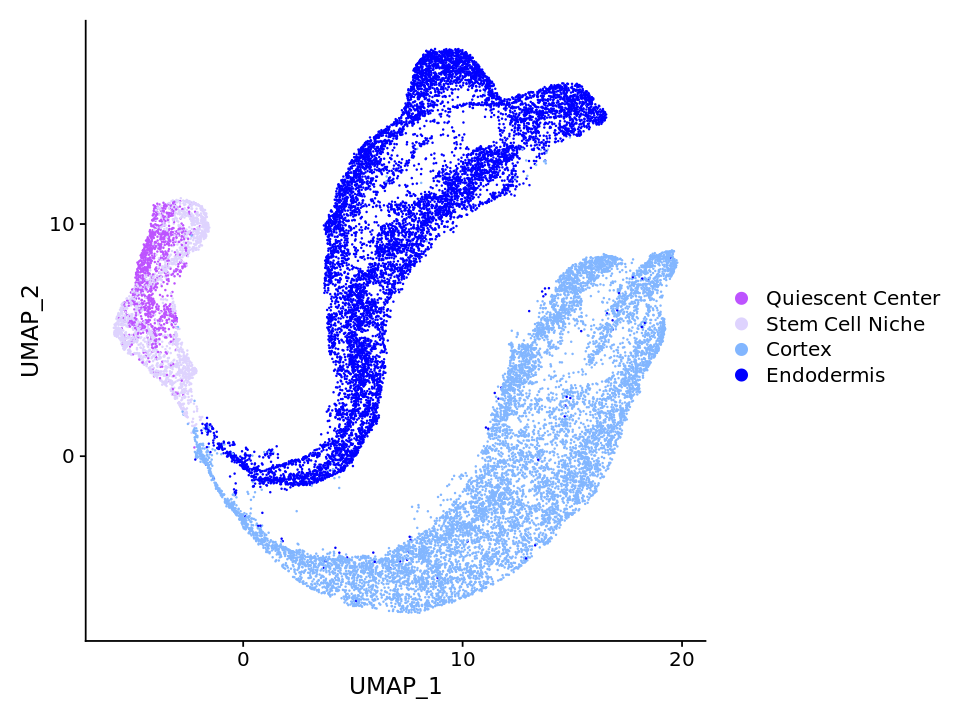

In [5]:
options(repr.plot.width=8, repr.plot.height=6)
DimPlot(rc.integrated, reduction = "umap", group.by = "celltype.anno", cols=color)

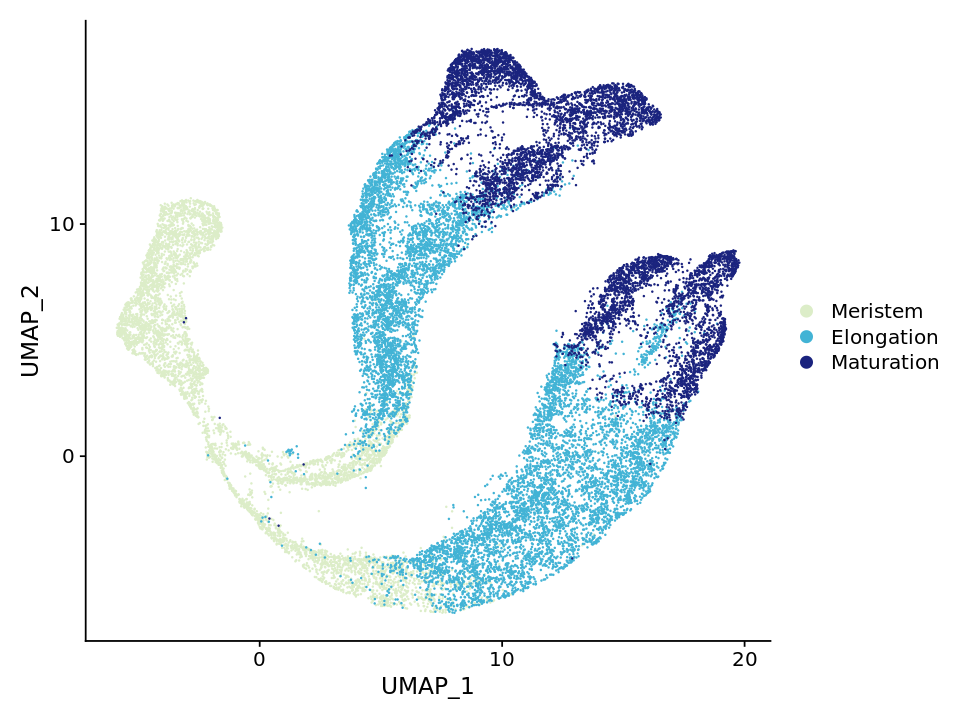

In [6]:
options(repr.plot.width=8, repr.plot.height=6)
time_plt <- DimPlot(rc.integrated, 
        group.by = "time.anno", 
        order = c("Maturation","Elongation","Meristem"),
        cols = c("#DCEDC8", "#42B3D5", "#1A237E"))
time_plt

In [7]:
table(rc.integrated$consensus.time.group)


  T0   T1   T2   T3   T4   T5   T6   T7   T8   T9 
2616  691 2025 3073 2884 2248 1986 2308 2706 3150 

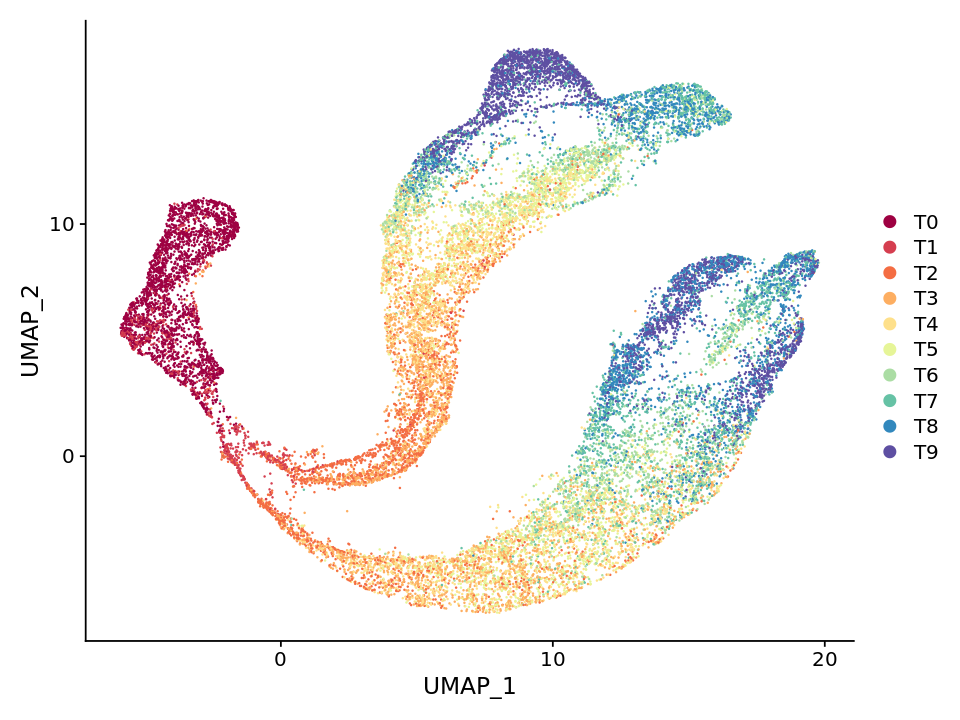

In [8]:
options(repr.plot.width=8, repr.plot.height=6)
DimPlot(rc.integrated, reduction = "umap", group.by = "consensus.time.group", cols=brewer.pal(10,"Spectral"))

In [9]:
# FindMarkers for celltype and time combination

rc.integrated$cell_group <- paste(rc.integrated$celltype.anno, rc.integrated$consensus.time.group, sep="_")

In [10]:
table(rc.integrated$cell_group)


          Cortex_T0           Cortex_T1           Cortex_T2           Cortex_T3 
                 11                 154                 664                1391 
          Cortex_T4           Cortex_T5           Cortex_T6           Cortex_T7 
               1272                1136                1106                1401 
          Cortex_T8           Cortex_T9       Endodermis_T0       Endodermis_T1 
               1670                1401                   6                 173 
      Endodermis_T2       Endodermis_T3       Endodermis_T4       Endodermis_T5 
               1333                1673                1611                1112 
      Endodermis_T6       Endodermis_T7       Endodermis_T8       Endodermis_T9 
                880                 906                1036                1749 
Quiescent Center_T0 Quiescent Center_T1 Quiescent Center_T2 Quiescent Center_T3 
               1070                 109                   9                   6 
Quiescent Center_T4  Stem C

In [11]:
table(rc.integrated$celltype.anno, rc.integrated$consensus.time.group)

                  
                     T0   T1   T2   T3   T4   T5   T6   T7   T8   T9
  Quiescent Center 1070  109    9    6    1    0    0    0    0    0
  Stem Cell Niche  1529  255   19    3    0    0    0    1    0    0
  Cortex             11  154  664 1391 1272 1136 1106 1401 1670 1401
  Endodermis          6  173 1333 1673 1611 1112  880  906 1036 1749

In [12]:
Idents(rc.integrated) <- "cell_group"

In [13]:
Clust_Markers <- FindAllMarkers(rc.integrated,
                                max.cells.per.ident = 5000,
                                only.pos=T, 
                               test.use="roc")

Calculating cluster Cortex_T6

Calculating cluster Endodermis_T4

Calculating cluster Quiescent Center_T0

Calculating cluster Endodermis_T5

Calculating cluster Cortex_T7

Calculating cluster Cortex_T9

Calculating cluster Endodermis_T1

Calculating cluster Cortex_T4

Calculating cluster Endodermis_T2

Calculating cluster Endodermis_T8

Calculating cluster Cortex_T5

Calculating cluster Endodermis_T7

Calculating cluster Stem Cell Niche_T1

Calculating cluster Cortex_T8

Calculating cluster Endodermis_T9

Calculating cluster Endodermis_T6

Calculating cluster Cortex_T1

Calculating cluster Stem Cell Niche_T0

Calculating cluster Cortex_T3

Calculating cluster Cortex_T2

Calculating cluster Endodermis_T3

Calculating cluster Quiescent Center_T2

Calculating cluster Quiescent Center_T1

Calculating cluster Cortex_T0

Calculating cluster Endodermis_T0

Calculating cluster Quiescent Center_T3

Calculating cluster Stem Cell Niche_T2

Calculating cluster Stem Cell Niche_T3

Calculating clus

In [14]:
feature_names <- read_tsv("./supp_data/features.tsv.gz", col_names = c("gene", "Name", "Type")) %>%
  select(-Type) %>%
  distinct()


Parsed with column specification:
cols(
  gene = col_character(),
  Name = col_character(),
  Type = col_character()
)



In [15]:
Clust_Markers <- left_join(Clust_Markers, feature_names)

Joining, by = "gene"



In [16]:
Clust_Markers %>% group_by(cluster) %>% tally()

cluster             n   
1  Cortex_T6            197
2  Endodermis_T4        342
3  Quiescent Center_T0 2974
4  Endodermis_T5        246
5  Cortex_T7            206
6  Cortex_T9            477
7  Endodermis_T1        838
8  Cortex_T4            506
9  Endodermis_T2        655
10 Endodermis_T8        655
11 Cortex_T5            417
12 Endodermis_T7        338
13 Stem Cell Niche_T1  2308
14 Cortex_T8            392
15 Endodermis_T9        824
16 Endodermis_T6        176
17 Cortex_T1            893
18 Stem Cell Niche_T0  2342
19 Cortex_T3            587
20 Cortex_T2            602
21 Endodermis_T3        475
22 Quiescent Center_T2  693
23 Quiescent Center_T1 2494
24 Cortex_T0            730
25 Endodermis_T0        556
26 Quiescent Center_T3  484
27 Stem Cell Niche_T2   543
28 Stem Cell Niche_T3   321

In [17]:
Clust_Markers %>% group_by(cluster) %>% top_n(1, myAUC)

myAUC avg_diff power pct.1 pct.2 cluster             gene      Name     
1  0.856 1.205016 0.712 0.880 0.260 Cortex_T6           AT1G53830 PME2     
2  0.905 2.065041 0.810 0.962 0.266 Endodermis_T4       AT5G13910 LEP      
3  0.970 4.127620 0.940 0.947 0.076 Quiescent Center_T0 AT2G28900 OEP161   
4  0.884 1.890056 0.768 0.979 0.353 Endodermis_T5       AT4G16447 AT4G16447
5  0.854 1.468730 0.708 0.944 0.335 Cortex_T7           AT1G62510 AT1G62510
6  0.959 2.668301 0.918 0.996 0.180 Cortex_T9           AT5G15180 PER56    
7  0.932 3.049382 0.864 0.925 0.157 Endodermis_T1       AT5G07030 AT5G07030
8  0.894 1.911377 0.788 0.967 0.284 Cortex_T4           AT5G11420 AT5G11420
9  0.915 2.317323 0.830 0.984 0.365 Endodermis_T2       AT1G11580 ATPMEPCRA
10 0.923 1.970303 0.846 0.990 0.220 Endodermis_T8       AT2G36100 CASP1    
11 0.877 1.772021 0.754 0.945 0.289 Cortex_T5           AT5G11420 AT5G11420
12 0.877 1.714200 0.754 0.939 0.222 Endodermis_T7       AT5G66390 PER72    
13 0.956 3.426599 0.912 0.976 0.176 Stem Cell Niche_T1  AT3G09200 RPP0B    
14 0.924 2.057510 0.848 0.955 0.173 Cortex_T8           AT5G15180 PER56    
15 0.970 3.264461 0.940 0.983 0.124 Endodermis_T9       AT2G39430 DIR9     
16 0.879 1.393007 0.758 0.995 0.470 Endodermis_T6       AT1G02900 RALF1    
17 0.963 3.489108 0.926 0.981 0.214 Cortex_T1           AT2G45050 GATA2    
18 0.968 2.961916 0.936 0.997 0.129 Stem Cell Niche_T0  AT3G09200 RPP0B    
19 0.968 2.888377 0.936 1.000 0.118 Stem Cell Niche_T0  AT5G16130 RPS7C    
20 0.968 2.788625 0.936 0.994 0.124 Stem Cell Niche_T0  AT2G39460 RPL23AA  
21 0.968 2.726530 0.936 0.995 0.119 Stem Cell Niche_T0  AT2G47610 RPL7AA   
22 0.900 1.881175 0.800 0.895 0.192 Cortex_T3           AT4G15160 AT4G15160
23 0.882 2.154604 0.764 0.916 0.319 Cortex_T2           AT5G62210 AT5G62210
24 0.914 2.105701 0.828 0.916 0.208 Endodermis_T3       AT1G62480 AT1G62480
25 0.958 1.837265 0.916 0.333 0.013 Quiescent Center_T2 AT2G21045 HAC1     
26 0.948 3.127919 0.896 0.982 0.173 Quiescent Center_T1 AT4G27090 RPL14B   
27 0.948 2.530051 0.896 0.991 0.185 Quiescent Center_T1 AT2G36160 RPS14A   
28 0.948 2.276780 0.896 0.991 0.203 Quiescent Center_T1 AT3G11940 RPS5B    
29 0.982 3.999549 0.964 1.000 0.296 Cortex_T0           AT1G17285 AT1G17285
30 0.989 3.843861 0.978 1.000 0.191 Endodermis_T0       AT1G46264 HSFB4    
31 0.971 1.578438 0.942 1.000 0.101 Quiescent Center_T3 AT2G27660 AT2G27660
32 0.915 1.526114 0.830 1.000 0.194 Stem Cell Niche_T2  AT3G49910 RPL26A   
33 0.980 1.980435 0.960 0.667 0.015 Stem Cell Niche_T3  AT1G23540 PERK12

In [18]:
Clust_Markers <- separate(Clust_Markers, cluster, into=c("celltype", "stage"), sep="_", remove=F)

In [19]:
Clust_Markers <- mutate(Clust_Markers, pct.diff=pct.1-pct.2)

Clust_Markers <- arrange(Clust_Markers, desc(pct.diff)) %>%
group_by(cluster) %>%
mutate(pct.diff_rank=dplyr::row_number()) %>%
arrange(desc(avg_diff)) %>%
mutate(avg_diff_rank=dplyr::row_number()) %>%
arrange(desc(myAUC)) %>%
mutate(myAUC_rank=dplyr::row_number()) %>%
mutate(combined_rank_raw=(pct.diff_rank + avg_diff_rank + myAUC_rank)/3) %>%
arrange(combined_rank_raw) %>%
mutate(combined_rank=dplyr::row_number()) %>%
select(-combined_rank_raw) %>%
arrange(combined_rank)
Clust_Markers

myAUC avg_diff  power pct.1 pct.2 cluster             celltype        
1     0.905 2.065041  0.810 0.962 0.266 Endodermis_T4       Endodermis      
2     0.963 3.489108  0.926 0.981 0.214 Cortex_T1           Cortex          
3     0.914 2.105701  0.828 0.916 0.208 Endodermis_T3       Endodermis      
4     0.932 3.049382  0.864 0.925 0.157 Endodermis_T1       Endodermis      
5     0.877 2.006630  0.754 0.939 0.270 Cortex_T4           Cortex          
6     0.897 5.546018  0.794 0.947 0.208 Stem Cell Niche_T2  Stem Cell Niche 
7     0.971 4.629008  0.942 1.000 0.123 Endodermis_T0       Endodermis      
8     0.888 2.425591  0.776 0.887 0.164 Endodermis_T2       Endodermis      
9     0.855 1.927837  0.710 0.910 0.270 Endodermis_T5       Endodermis      
10    0.853 1.480919  0.706 0.942 0.339 Cortex_T6           Cortex          
11    0.870 1.840986  0.740 0.913 0.276 Cortex_T5           Cortex          
12    0.828 1.928055  0.656 0.762 0.204 Cortex_T7           Cortex          
13    0.825 2.048860  0.650 0.770 0.201 Endodermis_T6       Endodermis      
14    0.931 3.083262  0.862 0.935 0.172 Cortex_T9           Cortex          
15    0.970 4.318500  0.940 1.000 0.128 Cortex_T0           Cortex          
16    0.970 4.127620  0.940 0.947 0.076 Quiescent Center_T0 Quiescent Center
17    0.870 2.144005  0.740 0.914 0.299 Cortex_T3           Cortex          
18    0.958 5.959116  0.916 1.000 0.233 Stem Cell Niche_T3  Stem Cell Niche 
19    0.866 2.443180  0.732 0.848 0.254 Cortex_T2           Cortex          
20    0.969 4.510591  0.938 0.972 0.270 Endodermis_T9       Endodermis      
21    0.954 5.596575  0.908 0.833 0.058 Quiescent Center_T3 Quiescent Center
22    0.895 2.156438  0.790 0.811 0.157 Cortex_T8           Cortex          
23    0.871 1.740978  0.742 0.937 0.227 Endodermis_T7       Endodermis      
24    0.842 2.577315  0.684 0.682 0.140 Endodermis_T8       Endodermis      
25    0.955 3.517442  0.910 0.988 0.162 Stem Cell Niche_T1  Stem Cell Niche 
26    0.904 4.995143  0.808 0.889 0.232 Quiescent Center_T2 Quiescent Center
27    0.944 3.312269  0.888 0.972 0.174 Quiescent Center_T1 Quiescent Center
28    0.966 3.074498  0.932 0.997 0.119 Stem Cell Niche_T0  Stem Cell Niche 
29    0.890 2.150164  0.780 0.877 0.222 Endodermis_T3       Endodermis      
30    0.958 3.267070  0.916 0.994 0.244 Cortex_T1           Cortex          
⋮     ⋮     ⋮         ⋮     ⋮     ⋮     ⋮                   ⋮               
22242 0.709 0.4398841 0.418 0.636 0.287 Quiescent Center_T0 Quiescent Center
22243 0.293 0.8583274 0.414 0.116 0.383 Quiescent Center_T0 Quiescent Center
22244 0.716 0.3464274 0.432 0.480 0.222 Quiescent Center_T0 Quiescent Center
22245 0.712 0.3679475 0.424 0.623 0.296 Quiescent Center_T0 Quiescent Center
22246 0.709 0.2923628 0.418 0.626 0.265 Quiescent Center_T0 Quiescent Center
22247 0.710 0.5091897 0.420 0.149 0.062 Quiescent Center_T0 Quiescent Center
22248 0.702 0.4429152 0.404 0.641 0.269 Quiescent Center_T0 Quiescent Center
22249 0.704 0.2967455 0.408 0.681 0.303 Quiescent Center_T0 Quiescent Center
22250 0.703 0.6356933 0.406 0.464 0.189 Quiescent Center_T0 Quiescent Center
22251 0.703 0.2511803 0.406 0.522 0.137 Quiescent Center_T0 Quiescent Center
22252 0.707 0.4744763 0.414 0.584 0.295 Quiescent Center_T0 Quiescent Center
22253 0.278 0.7411596 0.444 0.081 0.253 Quiescent Center_T0 Quiescent Center
22254 0.293 0.6914392 0.414 0.079 0.216 Quiescent Center_T0 Quiescent Center
22255 0.706 0.2735627 0.412 0.664 0.321 Quiescent Center_T0 Quiescent Center
22256 0.703 0.3623966 0.406 0.559 0.218 Quiescent Center_T0 Quiescent Center
22257 0.707 0.3663619 0.414 0.536 0.266 Quiescent Center_T0 Quiescent Center
22258 0.280 0.6186978 0.440 0.070 0.305 Quiescent Center_T0 Quiescent Center
22259 0.264 0.6241945 0.472 0.009 0.199 Quiescent Center_T0 Quiescent Center
22260 0.294 0.5597900 0.412 0.125 0.278 Quiescent Center_T0 Quiescent Center
22261 0.210 0.5483361 0.580 0.100 0.524 Quiescent Center_T0 Quiescent Center
22

In [20]:
filter(Clust_Markers, celltype %in% c("Cortex", "Endodermis") & myAUC>=0.75) %>%
group_by(celltype) %>% 
tally()

celltype   n   
1 Cortex     2740
2 Endodermis 2773

In [21]:
filter(Clust_Markers, celltype %in% c("Cortex", "Endodermis") & myAUC>=0.75) %>%
group_by(cluster) %>% 
tally()

cluster       n  
1  Cortex_T6      76
2  Endodermis_T4 184
3  Endodermis_T5 121
4  Cortex_T7      84
5  Cortex_T9     271
6  Endodermis_T1 493
7  Cortex_T4     249
8  Endodermis_T2 337
9  Endodermis_T8 285
10 Cortex_T5     188
11 Endodermis_T7  77
12 Cortex_T8     186
13 Endodermis_T9 448
14 Endodermis_T6  69
15 Cortex_T1     601
16 Cortex_T3     281
17 Cortex_T2     253
18 Endodermis_T3 253
19 Cortex_T0     551
20 Endodermis_T0 506

In [22]:
table(Clust_Markers$stage)


  T0   T1   T2   T3   T4   T5   T6   T7   T8   T9 
6602 6533 2493 1867  848  663  373  544 1047 1301 

In [23]:
Clust_Markers$stage <- factor(Clust_Markers$stage, levels=c("T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9"))

In [24]:
# write markers with AUC 0.75 and above to a csv
# "Cortex", "Endodermis"

Clust_Markers_to_write <- filter(Clust_Markers, celltype %in% c("Cortex", "Endodermis") & myAUC>=0.75) %>% arrange(celltype) %>% arrange(stage) %>% arrange(combined_rank)

write.csv(Clust_Markers_to_write, "./supp_data/WT_Endodermis_Cortex_markers_AUC_0.75.csv", row.names=F)

In [25]:
number_de_genes <- filter(Clust_Markers, celltype %in% c("Cortex", "Endodermis") & myAUC>=0.75) %>%
group_by(cluster) %>% 
tally() %>%
separate(cluster, into=c("celltype", "stage"), sep="_")

In [26]:
number_de_genes$stage <- factor(number_de_genes$stage, levels=c("T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9"))

(number_de_genes <- arrange(number_de_genes, celltype) %>% arrange(stage) %>% rename("n_de_genes"=n))

write.csv(number_de_genes, "./supp_data/WT_Endodermis_Cortex_markers_AUC_0.75_n_DE.csv", row.names=F)

celltype   stage n_de_genes
1  Cortex     T0    551       
2  Endodermis T0    506       
3  Cortex     T1    601       
4  Endodermis T1    493       
5  Cortex     T2    253       
6  Endodermis T2    337       
7  Cortex     T3    281       
8  Endodermis T3    253       
9  Cortex     T4    249       
10 Endodermis T4    184       
11 Cortex     T5    188       
12 Endodermis T5    121       
13 Cortex     T6     76       
14 Endodermis T6     69       
15 Cortex     T7     84       
16 Endodermis T7     77       
17 Cortex     T8    186       
18 Endodermis T8    285       
19 Cortex     T9    271       
20 Endodermis T9    448

In [20]:
table(Clust_Markers$stage)


  T0   T1   T2   T3   T4   T5   T6   T7   T8   T9 
6602 6533 2493 1867  848  663  373  544 1047 1301 

In [21]:
Clust_Markers$stage <- factor(Clust_Markers$stage, levels=c("T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9"))

In [22]:
rc.integrated$consensus.time.group <- factor(rc.integrated$consensus.time.group, levels=c("T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9"))

In [23]:
Idents(rc.integrated) <- "consensus.time.group"

In [24]:
# pseudobulk of each stage

  afm <- as.matrix(rc.integrated@assays$integrated@data)
  pooled <- matrix(nrow=nrow(afm), ncol = 0)

  for (i in unique(rc.integrated@meta.data$consensus.time.group)) {
    m <- afm[,which(rc.integrated@meta.data$consensus.time.group==i)]
    pooled <- cbind(pooled, rowSums(m)/ncol(m))
  }



In [25]:
unique(rc.integrated@meta.data$consensus.time.group)

[1] T6 T4 T0 T5 T7 T9 T1 T2 T8 T3
Levels: T0 T1 T2 T3 T4 T5 T6 T7 T8 T9

In [26]:
colnames(pooled) <- unique(rc.integrated@meta.data$consensus.time.group)

In [27]:
pooled_df <- as_tibble(pooled, rownames = "gene")

In [28]:
pooled_df_long <- pivot_longer(pooled_df, cols = 2:ncol(pooled_df), names_to = "stage", values_to = "expression")

In [29]:
long_order <- tibble(stage=paste("T", rep(0:9), sep=""), 
                     order=rep(1:10))

In [30]:
long_order

stage order
1  T0     1   
2  T1     2   
3  T2     3   
4  T3     4   
5  T4     5   
6  T5     6   
7  T6     7   
8  T7     8   
9  T8     9   
10 T9    10

In [31]:
(pooled_df_long <- left_join(pooled_df_long, long_order) %>%
arrange(order))

Joining, by = "stage"



gene      stage expression  order
1      AT1G05260 T0    -1.3516726  1    
2      AT3G59370 T0    -2.1513758  1    
3      AT2G36100 T0    -0.6383763  1    
4      AT1G12080 T0    -2.4976900  1    
5      AT1G12090 T0    -1.6171799  1    
6      AT4G11290 T0    -1.3316102  1    
7      AT5G42180 T0    -0.6286645  1    
8      AT5G66390 T0    -0.7878878  1    
9      AT2G32300 T0    -1.2041023  1    
10     AT2G02130 T0    -2.3199930  1    
11     AT3G11550 T0    -0.4964236  1    
12     AT4G35350 T0    -0.5789669  1    
13     AT1G30750 T0    -0.3738543  1    
14     AT4G40090 T0    -0.9599067  1    
15     AT1G20850 T0    -0.5948354  1    
16     AT2G39430 T0    -0.4248459  1    
17     AT1G75750 T0    -4.2272239  1    
18     AT4G13580 T0    -0.5016861  1    
19     AT4G25820 T0    -0.7724242  1    
20     AT4G23690 T0    -1.4574134  1    
21     AT1G26820 T0    -0.6574867  1    
22     AT5G64100 T0    -2.2673961  1    
23     AT1G65310 T0    -1.0470487  1    
24     AT2G40113 T0    -0.3917306  1    
25     AT5G17820 T0    -2.4571623  1    
26     AT3G24020 T0    -0.4573214  1    
27     AT5G04200 T0    -0.6287078  1    
28     AT3G54580 T0    -1.1990605  1    
29     AT3G09925 T0    -1.0756698  1    
30     AT5G46900 T0    -2.8311816  1    
⋮      ⋮         ⋮     ⋮           ⋮    
175101 AT4G22220 T9    -0.09076641 10   
175102 AT2G23090 T9     0.07411780 10   
175103 AT2G46490 T9    -0.40306050 10   
175104 AT3G27240 T9     0.45804627 10   
175105 AT1G07140 T9     0.02320155 10   
175106 AT1G76200 T9     0.42901140 10   
175107 AT5G08670 T9     0.31728448 10   
175108 AT1G04357 T9    -0.02749501 10   
175109 AT1G64230 T9     0.13560911 10   
175110 AT2G02050 T9     0.30469703 10   
175111 AT3G09840 T9     0.38223330 10   
175112 AT5G47030 T9     0.13726306 10   
175113 AT1G10590 T9    -0.32742186 10   
175114 AT1G08480 T9     0.29599851 10   
175115 AT5G61330 T9     0.02979260 10   
175116 AT4G02580 T9    -0.02726671 10   
175117 AT5G08060 T9     0.43588352 10   
175118 AT1G75950 T9    -0.22181267 10   
175119 AT2G20360 T9     0.35885526 10   
175120 AT4G30010 T9     0.33505934 10   
175121 AT4G06395 T9    -0.04340146 10   
175122 AT3G55440 T9     0.12716031 10   
175123 AT3G03100 T9     0.44475064 10   
175124 AT5G54760 T9    -0.09220133 10   
175125 AT2G33040 T9     0.34024512 10   
175126 AT2G42680 T9     0.05533355 10   
175127 AT5G11770 T9     0.41947123 10   
175128 AT5G08290 T9    -0.03036226 10   
175129 AT5G53300 T9     0.07503794 10   
175130 AT5G64400 T9     0.25739534 10

In [32]:
(long_corrs <- pooled_df_long %>%
group_by(gene) %>%
summarise(long_cor = cor(order, expression, method = "spearman")))

gene      long_cor   
1     AT1G01010  0.63636364
2     AT1G01020 -0.40606061
3     AT1G01030 -0.44242424
4     AT1G01040  0.68484848
5     AT1G01050 -0.91515152
6     AT1G01070  0.17575758
7     AT1G01080  0.28484848
8     AT1G01090 -0.89090909
9     AT1G01100 -0.91515152
10    AT1G01110 -0.70909091
11    AT1G01120  0.87878788
12    AT1G01130  0.20000000
13    AT1G01160 -0.44242424
14    AT1G01170  0.18787879
15    AT1G01180  0.91515152
16    AT1G01200  0.55151515
17    AT1G01210 -0.15151515
18    AT1G01220 -0.87878788
19    AT1G01225 -0.57575758
20    AT1G01230  0.05454545
21    AT1G01240  0.63636364
22    AT1G01260 -0.98787879
23    AT1G01290 -0.60000000
24    AT1G01300 -0.93939394
25    AT1G01310  0.84242424
26    AT1G01320  0.10303030
27    AT1G01340  0.96363636
28    AT1G01350  0.57575758
29    AT1G01360 -0.61212121
30    AT1G01370 -0.58787879
⋮     ⋮         ⋮          
17484 AT5G67320  0.17575758
17485 AT5G67330  0.92727273
17486 AT5G67340  0.92727273
17487 AT5G67360 -0.52727273
17488 AT5G67370  0.89090909
17489 AT5G67380  0.56363636
17490 AT5G67385 -0.23636364
17491 AT5G67390 -0.44242424
17492 AT5G67400  0.80606061
17493 AT5G67410 -0.75757576
17494 AT5G67420 -0.18787879
17495 AT5G67440  0.11515152
17496 AT5G67450  0.18787879
17497 AT5G67460 -0.13939394
17498 AT5G67470  0.01818182
17499 AT5G67488  0.04242424
17500 AT5G67500  0.89090909
17501 AT5G67510 -0.13939394
17502 AT5G67520  0.84242424
17503 AT5G67530 -0.87878788
17504 AT5G67540 -0.63636364
17505 AT5G67560  0.93939394
17506 AT5G67570 -0.95151515
17507 AT5G67580  0.57575758
17508 AT5G67590  1.00000000
17509 AT5G67600  0.52727273
17510 AT5G67610 -0.07878788
17511 AT5G67620  0.57575758
17512 AT5G67630 -0.12727273
17513 AT5G67640 -0.07878788

In [33]:
Clust_Markers <- left_join(Clust_Markers, long_corrs) %>%
mutate(abs_long_cor=abs(long_cor)) %>%
arrange(-abs_long_cor)
Clust_Markers

Joining, by = "gene"



myAUC avg_diff  power pct.1 pct.2 cluster             celltype        
1     0.879 1.3930070 0.758 0.995 0.470 Endodermis_T6       Endodermis      
2     0.840 1.4189937 0.680 0.956 0.500 Endodermis_T7       Endodermis      
3     0.828 1.1250108 0.656 0.991 0.469 Endodermis_T7       Endodermis      
4     0.877 3.0879477 0.754 0.924 0.398 Cortex_T9           Cortex          
5     0.833 1.1564966 0.666 0.988 0.465 Endodermis_T5       Endodermis      
6     0.803 1.0883300 0.606 0.817 0.317 Endodermis_T7       Endodermis      
7     0.795 1.9964275 0.590 0.801 0.286 Cortex_T8           Cortex          
8     0.911 3.3634513 0.822 0.917 0.314 Endodermis_T9       Endodermis      
9     0.804 1.7967179 0.608 0.827 0.314 Endodermis_T8       Endodermis      
10    0.943 4.0004641 0.886 0.957 0.216 Stem Cell Niche_T1  Stem Cell Niche 
11    0.858 1.7701728 0.716 0.949 0.433 Cortex_T8           Cortex          
12    0.853 2.5605563 0.706 0.884 0.306 Cortex_T9           Cortex          
13    0.931 2.3887577 0.862 0.987 0.437 Cortex_T9           Cortex          
14    0.943 1.8166062 0.886 1.000 0.219 Cortex_T0           Cortex          
15    0.939 4.0543701 0.878 0.976 0.483 Endodermis_T9       Endodermis      
16    0.871 1.5286624 0.742 0.963 0.497 Endodermis_T8       Endodermis      
17    0.846 3.0923324 0.692 0.930 0.454 Cortex_T9           Cortex          
18    0.864 3.3160146 0.728 0.895 0.327 Endodermis_T9       Endodermis      
19    0.859 2.3938925 0.718 0.879 0.288 Cortex_T9           Cortex          
20    0.795 2.0960510 0.590 0.689 0.262 Cortex_T8           Cortex          
21    0.849 3.9507765 0.698 0.848 0.315 Endodermis_T9       Endodermis      
22    0.813 0.6042155 0.626 0.871 0.349 Endodermis_T7       Endodermis      
23    0.899 3.7228308 0.798 0.937 0.447 Endodermis_T9       Endodermis      
24    0.750 1.6649955 0.500 0.837 0.499 Cortex_T7           Cortex          
25    0.961 2.7451014 0.922 0.990 0.130 Stem Cell Niche_T0  Stem Cell Niche 
26    0.853 2.6466808 0.706 0.937 0.456 Cortex_T9           Cortex          
27    0.789 2.0488152 0.578 0.882 0.464 Cortex_T8           Cortex          
28    0.945 3.1180694 0.890 0.973 0.177 Stem Cell Niche_T1  Stem Cell Niche 
29    0.864 2.5124816 0.728 0.963 0.482 Cortex_T9           Cortex          
30    0.792 1.6748999 0.584 0.793 0.339 Endodermis_T8       Endodermis      
⋮     ⋮     ⋮         ⋮     ⋮     ⋮     ⋮                   ⋮               
22242 0.710 1.6475751 0.420 0.625 0.170 Stem Cell Niche_T0  Stem Cell Niche 
22243 0.712 1.0772093 0.424 0.537 0.078 Stem Cell Niche_T1  Stem Cell Niche 
22244 0.766 0.8909212 0.532 0.537 0.178 Stem Cell Niche_T1  Stem Cell Niche 
22245 0.714 2.3876953 0.428 0.541 0.206 Quiescent Center_T1 Quiescent Center
22246 0.779 1.0260462 0.558 0.751 0.202 Quiescent Center_T0 Quiescent Center
22247 0.742 0.9216126 0.484 0.633 0.156 Quiescent Center_T1 Quiescent Center
22248 0.749 0.7386791 0.498 0.690 0.303 Stem Cell Niche_T1  Stem Cell Niche 
22249 0.735 1.7660291 0.470 0.578 0.205 Quiescent Center_T1 Quiescent Center
22250 0.706 1.6026120 0.412 0.670 0.282 Stem Cell Niche_T0  Stem Cell Niche 
22251 0.734 0.5767049 0.468 0.642 0.180 Quiescent Center_T1 Quiescent Center
22252 0.754 0.3859644 0.508 0.267 0.015 Stem Cell Niche_T1  Stem Cell Niche 
22253 0.706 1.0756543 0.412 0.500 0.088 Stem Cell Niche_T0  Stem Cell Niche 
22254 0.733 0.4212528 0.466 0.404 0.066 Stem Cell Niche_T1  Stem Cell Niche 
22255 0.741 1.4826601 0.482 0.639 0.142 Quiescent Center_T0 Quiescent Center
22256 0.805 0.4190904 0.610 0.707 0.216 Quiescent Center_T0 Quiescent Center
22257 0.714 1.1419359 0.428 0.509 0.220 Stem Cell Niche_T0  Stem Cell Niche 
22258 0.229 0.9117747 0.542 0.102 0.491 Stem Cell Niche_T1  Stem Cell Niche 
22259 0.765 0.5964699 0.530 0.440 0.104 Quiescent Center_T1 Quiescent Center
22260 0.244 0.5818456 0.512 0.090 0.470 Stem Cell Niche_T1  Stem Cell Niche 
22261 0.278 0.4957563 0.444 0.153 0.373 Stem Cell Niche_T1  Stem Cell Niche 
22

In [34]:
genes_to_plt_df <- filter(Clust_Markers, celltype %in% c("Endodermis")) %>%
group_by(stage) %>%
top_n(20, -combined_rank) %>%
top_n(10, abs_long_cor) %>%
ungroup() %>%
arrange(stage)
# genes manually added to plotting list - these are known markers we want to make sure are there
to_add <- filter(Clust_Markers, celltype %in% c("Endodermis")) %>% filter(Name=="SCR" | Name=="MYB36" | Name=="CASP4")

(genes_to_plt_df <- bind_rows(genes_to_plt_df, to_add) %>% 
 ungroup() %>% 
 group_by(gene) %>%
 top_n(1, -combined_rank) %>% # order genes by stage of highest rank
 ungroup() %>% arrange(stage))

genes_to_plt <- unique(genes_to_plt_df$gene)

genes_to_plt_endo <- rev(genes_to_plt) # order to pointing upwards

myAUC avg_diff power pct.1 pct.2 cluster       celltype   stage gene     
1  0.979 3.540977 0.958 1.000 0.251 Endodermis_T0 Endodermis T0    AT3G56220
2  0.987 5.282113 0.974 1.000 0.333 Endodermis_T0 Endodermis T0    AT3G52960
3  0.969 4.582115 0.938 1.000 0.245 Endodermis_T0 Endodermis T0    AT5G48660
4  0.976 3.658823 0.952 1.000 0.217 Endodermis_T0 Endodermis T0    AT2G20515
5  0.967 2.854138 0.934 1.000 0.219 Endodermis_T0 Endodermis T0    AT2G45050
6  0.954 3.330530 0.908 1.000 0.248 Endodermis_T0 Endodermis T0    AT3G60530
7  0.943 2.401987 0.886 1.000 0.128 Endodermis_T0 Endodermis T0    AT4G21960
8  0.989 3.843861 0.978 1.000 0.191 Endodermis_T0 Endodermis T0    AT1G46264
9  0.969 3.648240 0.938 1.000 0.210 Endodermis_T0 Endodermis T0    AT3G05190
10 0.880 2.890993 0.760 0.786 0.178 Endodermis_T1 Endodermis T1    AT5G27670
11 0.914 2.889564 0.828 0.902 0.263 Endodermis_T1 Endodermis T1    AT1G14900
12 0.918 2.741948 0.836 0.919 0.258 Endodermis_T1 Endodermis T1    AT5G59910
13 0.888 3.304299 0.776 0.902 0.297 Endodermis_T1 Endodermis T1    AT2G22230
14 0.883 2.800817 0.766 0.936 0.323 Endodermis_T1 Endodermis T1    AT2G43360
15 0.932 3.049382 0.864 0.925 0.157 Endodermis_T1 Endodermis T1    AT5G07030
16 0.902 3.055266 0.804 0.919 0.272 Endodermis_T1 Endodermis T1    AT5G28640
17 0.912 2.847639 0.824 0.936 0.287 Endodermis_T1 Endodermis T1    AT5G23860
18 0.913 2.624992 0.826 0.913 0.276 Endodermis_T1 Endodermis T1    AT3G45980
19 0.929 2.604359 0.858 0.931 0.161 Endodermis_T1 Endodermis T1    AT3G54560
20 0.864 1.858860 0.728 0.952 0.366 Endodermis_T2 Endodermis T2    AT4G16265
21 0.868 1.921904 0.736 0.890 0.282 Endodermis_T2 Endodermis T2    AT5G55730
22 0.873 2.639195 0.746 0.943 0.458 Endodermis_T2 Endodermis T2    AT1G54580
23 0.828 2.409404 0.656 0.875 0.346 Endodermis_T2 Endodermis T2    AT4G39900
24 0.822 2.842089 0.644 0.809 0.196 Endodermis_T2 Endodermis T2    AT4G17970
25 0.826 2.782040 0.652 0.797 0.134 Endodermis_T2 Endodermis T2    AT1G65900
26 0.888 2.425591 0.776 0.887 0.164 Endodermis_T2 Endodermis T2    AT3G23730
27 0.909 2.192674 0.818 0.950 0.255 Endodermis_T2 Endodermis T2    AT5G63660
28 0.841 2.309841 0.682 0.932 0.413 Endodermis_T2 Endodermis T2    AT1G13280
29 0.830 2.356682 0.660 0.884 0.388 Endodermis_T2 Endodermis T2    AT3G54220
30 0.830 1.945394 0.660 0.848 0.206 Endodermis_T3 Endodermis T3    AT5G45200
⋮  ⋮     ⋮        ⋮     ⋮     ⋮     ⋮             ⋮          ⋮     ⋮        
62 0.817 1.614635 0.634 0.917 0.467 Endodermis_T6 Endodermis T6    AT5G25770
63 0.840 1.418994 0.680 0.956 0.500 Endodermis_T7 Endodermis T7    AT5G58375
64 0.863 1.728407 0.726 0.970 0.498 Endodermis_T7 Endodermis T7    AT3G06125
65 0.783 2.031473 0.566 0.854 0.394 Endodermis_T7 Endodermis T7    AT5G21090
66 0.771 1.834036 0.542 0.843 0.379 Endodermis_T7 Endodermis T7    AT5G42030
67 0.877 1.714200 0.754 0.939 0.222 Endodermis_T7 Endodermis T7    AT5G66390
68 0.803 1.691173 0.606 0.902 0.446 Endodermis_T7 Endodermis T7    AT3G09270
69 0.816 1.726262 0.632 0.852 0.296 Endodermis_T7 Endodermis T7    AT4G23493
70 0.790 1.853027 0.580 0.666 0.234 Endodermis_T7 Endodermis T7    AT5G08240
71 0.837 1.755929 0.674 0.699 0.131 Endodermis_T7 Endodermis T7    AT4G21620
72 0.796 1.894745 0.592 0.799 0.318 Endodermis_T7 Endodermis T7    AT2G15340
73 0.819 1.715191 0.638 0.800 0.310 Endodermis_T7 Endodermis T7    AT4G34230
74 0.847 2.180772 0.694 0.842 0.189 Endodermis_T8 Endodermis T8    AT3G03520
75 0.821 2.521237 0.642 0.709 0.163 Endodermis_T8 Endodermis T8    AT3G14280
76 0.841 2.047616 0.682 0.860 0.183 Endodermis_T8 Endodermis T8    AT4G13580
77 0.842 2.577315 0.684 0.682 0.140 Endodermis_T8 Endodermis T8    AT1G03850
78 0.821 2.266373 0.642 0.728 0.206 Endodermis_T8 Endodermis T8    AT4G37790
79 0.923 1.970303 0.846 0.990 0.220 Endodermis_T8 Endodermis T8    AT2G36100
80 0.829 1.998127 0.658 0.869 0.146 Endodermis_T8 Endodermis T8    AT3G24020
81 0.962 3.373094 0.924 0.977 0.282 Endodermis_T9 Endodermis T9    AT4G34050

In [35]:
genes_to_plt_df <- filter(Clust_Markers, celltype %in% c("Cortex")) %>%
group_by(stage) %>%
top_n(20, -combined_rank) %>%
top_n(10, abs_long_cor) %>%
ungroup() %>%
arrange(stage)

# to add AT4G09760 AT5G02000

to_add <- filter(Clust_Markers, celltype %in% c("Cortex")) %>% filter(gene %in% c("AT4G09760", "AT5G02000", "AT5G64620"))

(genes_to_plt_df <- bind_rows(genes_to_plt_df, to_add) %>% 
 ungroup() %>% 
 group_by(gene) %>%
 top_n(1, -combined_rank) %>%
 ungroup() %>% arrange(stage))



(genes_to_plt_df <- genes_to_plt_df %>% 
 ungroup() %>% 
 group_by(gene) %>%
 top_n(1, -combined_rank) %>%
 ungroup() %>% arrange(stage))

genes_to_plt <- unique(genes_to_plt_df$gene)

genes_to_plt_cortex <- genes_to_plt

myAUC avg_diff power pct.1 pct.2 cluster   celltype stage gene     
1  0.975 3.986648 0.950 1.000 0.268 Cortex_T0 Cortex   T0    AT3G18000
2  0.943 2.780227 0.886 1.000 0.237 Cortex_T0 Cortex   T0    AT1G68560
3  0.974 4.538078 0.948 1.000 0.265 Cortex_T0 Cortex   T0    AT2G24280
4  0.953 3.219154 0.906 1.000 0.248 Cortex_T0 Cortex   T0    AT3G09455
5  0.948 4.537872 0.896 1.000 0.333 Cortex_T0 Cortex   T0    AT3G52960
6  0.919 4.323496 0.838 1.000 0.304 Cortex_T0 Cortex   T0    AT3G54960
7  0.931 4.130125 0.862 0.909 0.215 Cortex_T0 Cortex   T0    AT2G34020
8  0.980 3.939101 0.960 1.000 0.217 Cortex_T0 Cortex   T0    AT2G20515
9  0.979 3.617922 0.958 1.000 0.219 Cortex_T0 Cortex   T0    AT2G45050
10 0.933 3.759440 0.866 1.000 0.283 Cortex_T0 Cortex   T0    AT5G05890
11 0.923 3.022778 0.846 0.955 0.306 Cortex_T1 Cortex   T1    AT4G34200
12 0.893 3.399773 0.786 0.961 0.315 Cortex_T1 Cortex   T1    AT2G21250
13 0.905 3.349306 0.810 0.955 0.252 Cortex_T1 Cortex   T1    AT1G09580
14 0.879 3.166858 0.758 0.883 0.235 Cortex_T1 Cortex   T1    AT5G22580
15 0.924 3.115827 0.848 0.961 0.319 Cortex_T1 Cortex   T1    AT5G50375
16 0.901 2.453529 0.802 0.909 0.246 Cortex_T1 Cortex   T1    AT3G56220
17 0.929 3.022598 0.858 0.987 0.387 Cortex_T1 Cortex   T1    AT5G48580
18 0.833 2.175001 0.666 0.797 0.282 Cortex_T2 Cortex   T2    AT1G17285
19 0.866 2.443180 0.732 0.848 0.254 Cortex_T2 Cortex   T2    AT5G14020
20 0.842 2.096064 0.684 0.854 0.315 Cortex_T2 Cortex   T2    AT5G67070
21 0.834 2.252201 0.668 0.863 0.377 Cortex_T2 Cortex   T2    AT1G64900
22 0.840 2.774122 0.680 0.887 0.433 Cortex_T2 Cortex   T2    AT3G19820
23 0.830 2.460456 0.660 0.770 0.233 Cortex_T2 Cortex   T2    AT3G60530
24 0.837 2.268621 0.674 0.827 0.279 Cortex_T2 Cortex   T2    AT5G35740
25 0.808 2.569762 0.616 0.825 0.368 Cortex_T2 Cortex   T2    AT1G21750
26 0.850 2.456999 0.700 0.878 0.339 Cortex_T2 Cortex   T2    AT5G66590
27 0.838 1.803168 0.676 0.895 0.332 Cortex_T2 Cortex   T2    AT5G02000
28 0.877 2.052181 0.754 0.931 0.286 Cortex_T3 Cortex   T3    AT5G12940
29 0.840 2.054801 0.680 0.891 0.318 Cortex_T3 Cortex   T3    AT1G70280
30 0.834 2.245802 0.668 0.907 0.406 Cortex_T3 Cortex   T3    AT4G03190
⋮  ⋮     ⋮        ⋮     ⋮     ⋮     ⋮         ⋮        ⋮     ⋮        
63 0.826 1.300425 0.652 0.888 0.352 Cortex_T7 Cortex   T7    AT5G60660
64 0.853 1.595289 0.706 0.804 0.245 Cortex_T7 Cortex   T7    AT3G01190
65 0.784 1.917820 0.568 0.609 0.192 Cortex_T7 Cortex   T7    AT1G66725
66 0.822 1.142579 0.644 0.903 0.352 Cortex_T7 Cortex   T7    AT3G14690
67 0.779 1.619907 0.558 0.667 0.193 Cortex_T7 Cortex   T7    AT4G00330
68 0.854 1.468730 0.708 0.944 0.335 Cortex_T7 Cortex   T7    AT1G62510
69 0.809 2.041662 0.618 0.698 0.223 Cortex_T7 Cortex   T7    AT2G39110
70 0.822 1.431337 0.644 0.820 0.318 Cortex_T7 Cortex   T7    AT2G34500
71 0.855 2.241890 0.710 0.864 0.327 Cortex_T8 Cortex   T8    AT4G37010
72 0.872 1.976096 0.744 0.779 0.176 Cortex_T8 Cortex   T8    AT5G63600
73 0.897 1.873064 0.794 0.994 0.348 Cortex_T8 Cortex   T8    AT3G57020
74 0.868 1.968275 0.736 0.914 0.363 Cortex_T8 Cortex   T8    AT4G23400
75 0.924 2.057510 0.848 0.955 0.173 Cortex_T8 Cortex   T8    AT5G15180
76 0.904 2.091183 0.808 0.790 0.106 Cortex_T8 Cortex   T8    AT5G64100
77 0.851 2.362429 0.702 0.754 0.189 Cortex_T8 Cortex   T8    AT2G31570
78 0.841 2.095164 0.682 0.781 0.210 Cortex_T8 Cortex   T8    AT1G47480
79 0.861 1.937981 0.722 0.877 0.246 Cortex_T8 Cortex   T8    AT4G02700
80 0.878 1.879211 0.756 0.915 0.270 Cortex_T8 Cortex   T8    AT5G19240
81 0.775 2.112077 0.550 0.678 0.197 Cortex_T8 Cortex   T8    AT4G09760
82 0.931 3.083262 0.862 0.935 0.172 Cortex_T9 Cortex   T9    AT5G44480
83 0.931 2.639633 0.862 0.959 0.183 Cortex_T9 Cortex   T9    AT5G44380
84 0.937 2.614455 0.874 0.958 0.196 Cortex_T9 Cortex   T9    AT4G17340
85 0.885 2.760809 0.770 0.802 0.094 Cortex_T9 Cortex   T9    AT5G49760
86 0.860 3.153148 0.720 0.788 0.140 Cortex_T9 Cortex   T9    AT2G43050
87 0.889 2.822521 0.778 0.8

myAUC avg_diff power pct.1 pct.2 cluster   celltype stage gene     
1  0.975 3.986648 0.950 1.000 0.268 Cortex_T0 Cortex   T0    AT3G18000
2  0.943 2.780227 0.886 1.000 0.237 Cortex_T0 Cortex   T0    AT1G68560
3  0.974 4.538078 0.948 1.000 0.265 Cortex_T0 Cortex   T0    AT2G24280
4  0.953 3.219154 0.906 1.000 0.248 Cortex_T0 Cortex   T0    AT3G09455
5  0.948 4.537872 0.896 1.000 0.333 Cortex_T0 Cortex   T0    AT3G52960
6  0.919 4.323496 0.838 1.000 0.304 Cortex_T0 Cortex   T0    AT3G54960
7  0.931 4.130125 0.862 0.909 0.215 Cortex_T0 Cortex   T0    AT2G34020
8  0.980 3.939101 0.960 1.000 0.217 Cortex_T0 Cortex   T0    AT2G20515
9  0.979 3.617922 0.958 1.000 0.219 Cortex_T0 Cortex   T0    AT2G45050
10 0.933 3.759440 0.866 1.000 0.283 Cortex_T0 Cortex   T0    AT5G05890
11 0.923 3.022778 0.846 0.955 0.306 Cortex_T1 Cortex   T1    AT4G34200
12 0.893 3.399773 0.786 0.961 0.315 Cortex_T1 Cortex   T1    AT2G21250
13 0.905 3.349306 0.810 0.955 0.252 Cortex_T1 Cortex   T1    AT1G09580
14 0.879 3.166858 0.758 0.883 0.235 Cortex_T1 Cortex   T1    AT5G22580
15 0.924 3.115827 0.848 0.961 0.319 Cortex_T1 Cortex   T1    AT5G50375
16 0.901 2.453529 0.802 0.909 0.246 Cortex_T1 Cortex   T1    AT3G56220
17 0.929 3.022598 0.858 0.987 0.387 Cortex_T1 Cortex   T1    AT5G48580
18 0.833 2.175001 0.666 0.797 0.282 Cortex_T2 Cortex   T2    AT1G17285
19 0.866 2.443180 0.732 0.848 0.254 Cortex_T2 Cortex   T2    AT5G14020
20 0.842 2.096064 0.684 0.854 0.315 Cortex_T2 Cortex   T2    AT5G67070
21 0.834 2.252201 0.668 0.863 0.377 Cortex_T2 Cortex   T2    AT1G64900
22 0.840 2.774122 0.680 0.887 0.433 Cortex_T2 Cortex   T2    AT3G19820
23 0.830 2.460456 0.660 0.770 0.233 Cortex_T2 Cortex   T2    AT3G60530
24 0.837 2.268621 0.674 0.827 0.279 Cortex_T2 Cortex   T2    AT5G35740
25 0.808 2.569762 0.616 0.825 0.368 Cortex_T2 Cortex   T2    AT1G21750
26 0.850 2.456999 0.700 0.878 0.339 Cortex_T2 Cortex   T2    AT5G66590
27 0.838 1.803168 0.676 0.895 0.332 Cortex_T2 Cortex   T2    AT5G02000
28 0.877 2.052181 0.754 0.931 0.286 Cortex_T3 Cortex   T3    AT5G12940
29 0.840 2.054801 0.680 0.891 0.318 Cortex_T3 Cortex   T3    AT1G70280
30 0.834 2.245802 0.668 0.907 0.406 Cortex_T3 Cortex   T3    AT4G03190
⋮  ⋮     ⋮        ⋮     ⋮     ⋮     ⋮         ⋮        ⋮     ⋮        
63 0.826 1.300425 0.652 0.888 0.352 Cortex_T7 Cortex   T7    AT5G60660
64 0.853 1.595289 0.706 0.804 0.245 Cortex_T7 Cortex   T7    AT3G01190
65 0.784 1.917820 0.568 0.609 0.192 Cortex_T7 Cortex   T7    AT1G66725
66 0.822 1.142579 0.644 0.903 0.352 Cortex_T7 Cortex   T7    AT3G14690
67 0.779 1.619907 0.558 0.667 0.193 Cortex_T7 Cortex   T7    AT4G00330
68 0.854 1.468730 0.708 0.944 0.335 Cortex_T7 Cortex   T7    AT1G62510
69 0.809 2.041662 0.618 0.698 0.223 Cortex_T7 Cortex   T7    AT2G39110
70 0.822 1.431337 0.644 0.820 0.318 Cortex_T7 Cortex   T7    AT2G34500
71 0.855 2.241890 0.710 0.864 0.327 Cortex_T8 Cortex   T8    AT4G37010
72 0.872 1.976096 0.744 0.779 0.176 Cortex_T8 Cortex   T8    AT5G63600
73 0.897 1.873064 0.794 0.994 0.348 Cortex_T8 Cortex   T8    AT3G57020
74 0.868 1.968275 0.736 0.914 0.363 Cortex_T8 Cortex   T8    AT4G23400
75 0.924 2.057510 0.848 0.955 0.173 Cortex_T8 Cortex   T8    AT5G15180
76 0.904 2.091183 0.808 0.790 0.106 Cortex_T8 Cortex   T8    AT5G64100
77 0.851 2.362429 0.702 0.754 0.189 Cortex_T8 Cortex   T8    AT2G31570
78 0.841 2.095164 0.682 0.781 0.210 Cortex_T8 Cortex   T8    AT1G47480
79 0.861 1.937981 0.722 0.877 0.246 Cortex_T8 Cortex   T8    AT4G02700
80 0.878 1.879211 0.756 0.915 0.270 Cortex_T8 Cortex   T8    AT5G19240
81 0.775 2.112077 0.550 0.678 0.197 Cortex_T8 Cortex   T8    AT4G09760
82 0.931 3.083262 0.862 0.935 0.172 Cortex_T9 Cortex   T9    AT5G44480
83 0.931 2.639633 0.862 0.959 0.183 Cortex_T9 Cortex   T9    AT5G44380
84 0.937 2.614455 0.874 0.958 0.196 Cortex_T9 Cortex   T9    AT4G17340
85 0.885 2.760809 0.770 0.802 0.094 Cortex_T9 Cortex   T9    AT5G49760
86 0.860 3.153148 0.720 0.788 0.140 Cortex_T9 Cortex   T9    AT2G43050
87 0.889 2.822521 0.778 0.8

In [36]:
# subset for endodermis
Endo_QC  <- subset(rc.integrated, celltype.anno %in% c("Quiescent Center", "Stem Cell Niche", "Endodermis"))

In [37]:
# pseudobulk of each stage of endodermis


  afm <- as.matrix(Endo_QC@assays$integrated@data)
  pooled_endo <- matrix(nrow=nrow(afm), ncol = 0)

  for (i in unique(Endo_QC@meta.data$consensus.time.group)) {
    m <- afm[,which(Endo_QC@meta.data$consensus.time.group==i)]
    pooled_endo <- cbind(pooled_endo, rowSums(m)/ncol(m))
  }



In [38]:
colnames(pooled_endo) <- unique(Endo_QC@meta.data$consensus.time.group)

In [39]:
(endo_sub_m <- pooled_endo[genes_to_plt_endo, c("T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9")])

T0          T1          T2          T3           T4         
AT5G06200 -0.3858394  -0.39678862 -0.46835782 -0.46389492  -0.48952583
AT4G02090 -0.3510602  -0.39418992 -0.38203199 -0.42705875  -0.47492429
AT3G11550 -0.4953639  -0.46677592 -0.55521079 -0.55042610  -0.57283147
AT2G39430 -0.4245708  -0.42423281 -0.49306885 -0.50669223  -0.53260985
AT5G65020 -0.7931151  -0.78948578 -0.32828818 -0.31230876  -0.28326219
AT1G44970 -0.2927576  -0.31995370 -0.26834816 -0.17713949  -0.18024182
AT2G28671 -0.3952874  -0.36704201 -0.34483836 -0.38320250  -0.27876517
AT2G27370 -0.4853259  -0.47650478 -0.11488260 -0.07551403   0.19024764
AT1G80640 -0.1877883  -0.16877722  0.28451788  0.47826073   0.90848674
AT5G44790 -0.7297605  -0.82119706 -0.73355996 -0.66759998  -0.61724440
AT4G34050 -2.3566686  -1.79585068 -0.47006990 -0.19208806   0.33437955
AT3G24020 -0.4565064  -0.46963364 -0.49882608 -0.48197478  -0.58610801
AT2G36100 -0.6362937  -0.79475947 -0.93885657 -0.94604437  -0.83456318
AT4G37790 -0.7497711  -0.78208364 -0.60697921 -0.65552796  -0.13524968
AT1G03850 -1.2318407  -1.25238601 -1.30197303 -1.40730057  -1.44907875
AT4G13580 -0.5008437  -0.57179321 -0.54536763 -0.50029677  -0.54254935
AT3G14280 -0.8995567  -0.89017261 -0.90888272 -0.93598856  -0.88945990
AT3G03520 -0.6705847  -0.64697454 -0.56757028 -0.57162980  -0.46632306
AT4G34230 -1.2553710  -1.31421382 -1.14593246 -1.04647799  -0.24564486
AT2G15340 -0.2702526  -0.19758729  0.12811957  0.21321145   0.75248923
AT4G21620 -0.0665043  -0.08954689 -0.05389634 -0.06946120  -0.07707639
AT5G08240 -0.2973488  -0.30150312 -0.24060980 -0.23140286  -0.10279308
AT4G23493 -0.1952053  -0.11056667  0.20417212  0.24115336   0.37262324
AT3G09270 -0.5222286  -0.74368338 -0.41671205  0.12180841   0.97123311
AT5G66390 -0.7865327  -0.81235975 -0.66928313 -0.66204141  -0.27166507
AT5G42030 -0.5148810  -0.57885907 -0.36773895 -0.07448089   0.35071522
AT5G21090 -0.6161858  -0.67349504 -0.37545738 -0.30014663  -0.15925541
AT3G06125 -0.6865119  -0.50920953  0.06696524  0.46182362   0.85619254
AT5G58375 -0.7616663  -0.59264250  0.17898453  0.34310756   0.55534713
AT5G25770 -0.6668781  -0.44818145  0.84302848  1.17726542   1.96982016
⋮         ⋮           ⋮           ⋮           ⋮            ⋮          
AT5G45200 -0.09481253 1.5024485    4.16412767  3.330874408  2.27020679
AT3G54220  0.15997674 1.7797207    4.10576610  3.042229683  2.06278965
AT1G13280  0.26880004 1.0193887    2.85291382  2.291647806  1.48050830
AT5G63660  0.36195926 2.4154075    7.35964308  6.588208050  4.71766222
AT3G23730 -0.35037887 2.5205206    6.61675109  5.173271016  2.37608381
AT1G65900 -0.01302372 0.9910938    3.28294073  2.006943204  0.77087526
AT4G17970 -0.02894993 1.2838070    3.27922272  2.098688152  1.06279669
AT4G39900  0.48499954 1.0967093    2.27547823  1.772786166  1.03698218
AT1G54580  1.98266750 3.6876237    5.06381552  3.528433605  1.52791878
AT5G55730  0.98538782 0.9087416    2.36710946  2.008857118  1.13156187
AT4G16265  1.26690415 1.8487911    2.33976340  1.759547253  1.40929677
AT3G54560  2.14011718 3.7699787    2.93119285 -0.458639358 -0.75691234
AT3G45980  1.71533855 3.9356025    3.48103668 -0.004002006 -0.30807872
AT5G23860 -0.12136254 1.8044533    4.01882136  2.478177333  0.54894170
AT5G28640  1.18216201 2.7326165    2.21356819  0.829933580  0.11763119
AT5G07030  0.59139553 1.4820332    1.89946991  0.458414248 -0.45850379
AT2G43360  1.23429404 2.2113871    1.79956254  0.971765788  0.35059114
AT2G22230  1.39537303 2.3420559    1.37626325  0.606205010  0.03332351
AT5G59910  1.49903090 2.6081995    2.45248608 -0.333024403 -0.54318185
AT1G14900  0.98933524 1.9633546    2.52267063  0.158046980 -0.11178175
AT5G27670  0.66235104 1.3058391    1.74244736 -0.475760718 -0.56068768
AT3G05190  0.07519055 0.6095619    1.34615564  0.842070584  0.41259388
AT1G46264  0.56076769 1.5893468    1.64617315  0.813740282  0.20641275
AT4G21960  1.40392257 1.3224318   -1.46562244 -1.802413385 -2.03752283
AT3G60530  0.63304301 1.7916014   

In [40]:
# quantile normalize

mat = endo_sub_m
mat2 = t(apply(mat, 1, function(x) {
    q10 = quantile(x, 0.1)
    q90 = quantile(x, 0.9)
    x[x < q10] = q10
    x[x > q90] = q90
    scale(x)
}))
colnames(mat2) = colnames(mat)

In [41]:
# side annotation with color to match umap

endo_sa = rowAnnotation(foo = anno_block(gp = gpar(fill = "#0000FF"),
        labels = c("Endodermis"), 
        labels_gp = gpar(col = "white", fontsize = 18)))

In [42]:
# genes to mark on side of heatmap

(endo_mat_for_mark <- data.frame(mat2) %>% 
 rownames_to_column("gene") %>%
 left_join(feature_names) %>% 
 mutate(index=dplyr::row_number()) %>%
select(Name, index) %>%
filter(Name %in% c("XTH16", "SCR", "MYB36", "CASP1", "CASP2", "CASP3", "CASP4")))

Joining, by = "gene"



Name  index
1 CASP4  1   
2 CASP2  3   
3 CASP3  8   
4 CASP1 13   
5 MYB36 38   
6 SCR   63   
7 XTH16 66

In [43]:
# at - index of genes you want to mark
# labels - Names to show

endo_mark_anno = rowAnnotation(foo = anno_mark(at = endo_mat_for_mark$index, labels = endo_mat_for_mark$Name, labels_gp = gpar(col = "black", fontsize = 16)))

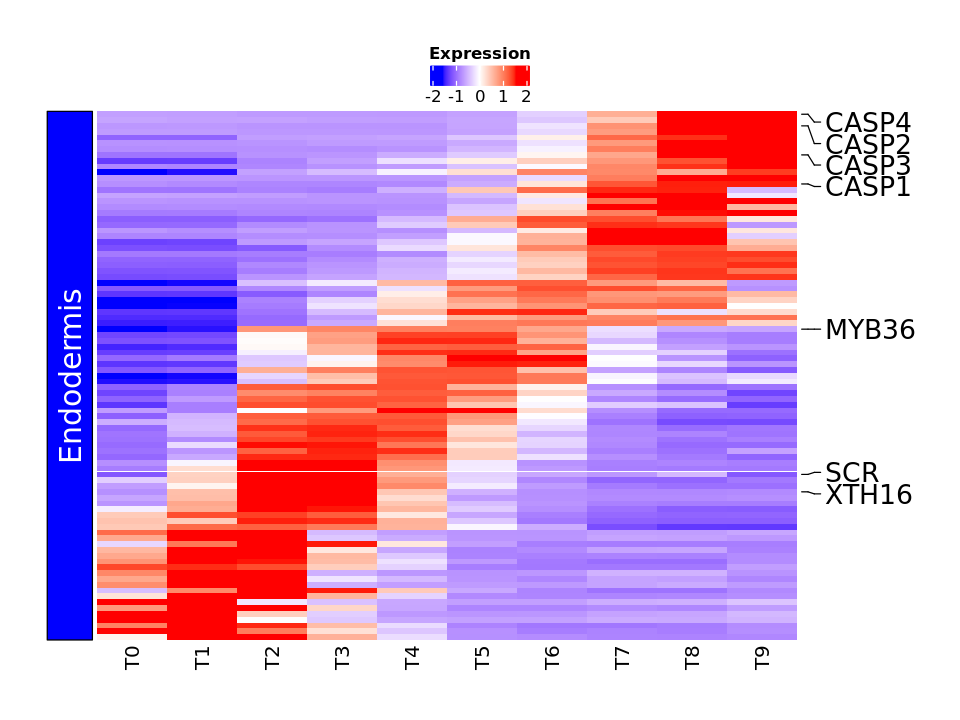

In [44]:
Endo_hm <- Heatmap(mat2, 
        col = colorRamp2(c(-1.5, 0, 1.5), 
                         c('blue','white','red')), 
                show_column_names = T,
                cluster_columns = F,
        cluster_rows=F,
                show_row_names = F, 
                   left_annotation=endo_sa,
                   right_annotation=endo_mark_anno,
               heatmap_legend_param = list(title_position="topcenter", title = "Expression", direction="horizontal"))

draw(Endo_hm, padding = unit(c(10, 10, 10, 10), "mm"), heatmap_legend_side = "top")


In [45]:
# cortex subset
Cor_QC  <- subset(rc.integrated, celltype.anno %in% c("Quiescent Center", "Stem Cell Niche", "Cortex"))

In [46]:
# pseudobulk of each stage of cortex


  afm <- as.matrix(Cor_QC@assays$integrated@data)
  pooled_cortex <- matrix(nrow=nrow(afm), ncol = 0)

  for (i in unique(Cor_QC@meta.data$consensus.time.group)) {
    m <- afm[,which(Cor_QC@meta.data$consensus.time.group==i)]
    pooled_cortex <- cbind(pooled_cortex, rowSums(m)/ncol(m))
  }



In [47]:
colnames(pooled_cortex) <- unique(Cor_QC@meta.data$consensus.time.group)

In [48]:
(cor_sub_m <- pooled_cortex[genes_to_plt_cortex, c("T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9")])

T0          T1          T2           T3          T4          
AT3G18000  1.4562981  2.1125168   1.5997758    0.65169036   0.374898469
AT1G68560  4.4787506  3.0739319   1.0652579    0.59338684   0.413303183
AT2G24280  0.2042816  1.2057138   1.4689425    0.88514567   0.651492691
AT3G09455  0.7182688  1.2554537   0.5397260    0.04164711  -0.116544105
AT3G52960  1.5390727  2.3881200   1.0458393    0.22814958   0.009500409
AT3G54960  0.3911053  0.4195276   1.3832326    1.04689142   0.789351731
AT2G34020  1.8289905  1.8994137   1.4074908    0.44504486   0.176480032
AT2G20515  3.2231088  3.7341010   1.8097634    0.34749119  -0.034612938
AT2G45050  2.2916836  3.1413238   2.7592212    0.61320732   0.068032506
AT5G05890  0.7411126  1.2563029   1.0261378    0.58056746   0.409808851
AT4G34200  1.2578353  1.8547471   1.2952311    0.72060000   0.434128960
AT2G21250  0.8682094  1.4787269   0.7793695    0.33277870   0.231478882
AT1G09580  0.2432141  0.7671110   0.8135735    0.47703912   0.305800011
AT5G22580  0.3572806  1.2460536   0.9498341    0.42652659   0.306227444
AT5G50375  1.3289030  2.3682748   1.9469846    1.07165610   0.786521380
AT3G56220  0.5786788  1.8167906   1.1875809    0.33771613   0.161842761
AT5G48580  0.8947607  1.9698352   2.0338974    1.54457345   1.132927316
AT1G17285  1.8383640  2.6602842   2.5820268    1.25017813   0.902320870
AT5G14020  0.7634415  1.0424673   2.2349459    1.63653425   1.368368296
AT5G67070  0.7460354  0.9545339   2.1293470    1.80099285   1.596632300
AT1G64900  0.7130032  2.1608697   2.8927648    2.17706666   1.953479232
AT3G19820  1.3133748  2.6944070   3.8528909    2.49157054   1.951764426
AT3G60530  0.6492327  2.5622119   3.1822560    1.43130204   0.931737454
AT5G35740  0.6210610  1.3746507   4.0589617    3.31610139   2.434884710
AT1G21750  0.2176770  0.8741291   2.1305997    1.49084877   1.164035768
AT5G66590  0.3815256  1.9312532   3.6327830    2.76766004   2.420213108
AT5G02000 -0.3663594  1.1285320   3.5346154    3.44047289   2.962183144
AT5G12940  1.2320877  0.8928704   3.3919811    4.27726503   4.167349446
AT1G70280  0.3661771  1.0269999   3.0596989    3.14198599   2.839073229
AT4G03190  0.2936854  0.9364230   3.3522713    3.79672850   3.453015156
⋮         ⋮           ⋮           ⋮            ⋮           ⋮           
AT1G13930 -1.34439814 -1.24318847 -0.362714271  0.18743191  0.7804779  
AT5G60660 -1.60946952 -1.53321725 -0.165286365  0.71116914  1.4491902  
AT3G01190 -2.14310665 -2.10293274 -0.850661305 -0.09404766  0.6804595  
AT1G66725 -0.86153200 -0.84108351 -0.641141255 -0.52232552 -0.4164361  
AT3G14690 -0.76544548 -0.76214837  0.159928914  0.44840504  0.6226270  
AT4G00330 -0.53802052 -0.57797100 -0.492804074 -0.39979331 -0.3386538  
AT2G39110 -0.65418419 -0.59779467 -0.252061715 -0.28854470 -0.1966902  
AT2G34500 -1.37885076 -1.33726846 -0.471559210  0.17799980  0.7357248  
AT4G37010 -1.17838814 -1.09931084 -0.197258517  0.08263832  0.1385279  
AT5G63600 -1.46831718 -1.37438446 -0.929264150 -0.86914562 -0.7610614  
AT3G57020 -1.36634336 -1.31987855  0.393026913  1.68484065  2.3100253  
AT4G23400 -1.70615084 -1.70766325 -0.830079621  0.03173150  0.6838932  
AT5G15180 -1.12361852 -1.14517530 -0.875267441 -0.81117368 -0.6915080  
AT5G64100 -2.26660195 -2.24833884 -2.136235952 -2.12521916 -2.0752466  
AT2G31570 -1.07351266 -1.12706740 -0.773450073 -0.67693510 -0.6763332  
AT1G47480 -0.64819059 -0.72291597 -0.315905773 -0.11735721 -0.0247899  
AT4G02700 -0.29910410 -0.32640221  0.007837718  0.01921877  0.0912477  
AT5G19240 -0.91065722 -1.01545920 -0.801134604 -0.77651091 -0.6862805  
AT4G09760 -0.06271868 -0.05907882 -0.275104369 -0.24630742 -0.2520515  
AT5G44480 -0.63419551 -0.65124105 -0.565513115 -0.53403700 -0.5054886  
AT5G44380 -2.05053479 -2.01778433 -1.492034250 -1.14733951 -0.7285131  
AT4G17340 -1.72964851 -1.71563588 -1.561866232 -1.57047345 -1.4031728  
AT5G49760 -0.51732096 -0.54572306 -0.435694449 -0.45147613 -0.4578218  
AT2G43050 -0.62801972 -0.63341185 -0.585217330 -0.

In [49]:
# annotation bar for consensus time

col_fun <- brewer.pal(10,"Spectral")

names(col_fun) <- c("T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9")
col_fun

ha = HeatmapAnnotation(`Consensus Time Group` = c("T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9"), col = list(`Consensus Time Group` = col_fun), show_legend = F)

T0        T1        T2        T3        T4        T5        T6        T7 
"#9E0142" "#D53E4F" "#F46D43" "#FDAE61" "#FEE08B" "#E6F598" "#ABDDA4" "#66C2A5" 
       T8        T9 
"#3288BD" "#5E4FA2"

In [50]:
# quantile normalize

mat = cor_sub_m
mat2 = t(apply(mat, 1, function(x) {
    q10 = quantile(x, 0.1)
    q90 = quantile(x, 0.9)
    x[x < q10] = q10
    x[x > q90] = q90
    scale(x)
}))
colnames(mat2) = colnames(mat)

In [51]:
# side annotation to match cortex colors

cortex_sa = rowAnnotation(foo = anno_block(gp = gpar(fill = "#82B6FF"),
        labels = c("Cortex"), 
        labels_gp = gpar(col = "black", fontsize = 18)))

In [52]:
# genes to label on side of heatmap for cortex

(cor_mat_for_mark <- data.frame(mat2) %>% 
 rownames_to_column("gene") %>%
 left_join(feature_names) %>% 
 mutate(index=dplyr::row_number()) %>%
select(Name, index) %>%
filter(Name %in% c("AT1G17285", "AT5G02000", "C/VIF2", "CYP72A15", "PER56", "PER69", "AT4G09760")))

Joining, by = "gene"



Name      index
1 AT1G17285 18   
2 AT5G02000 27   
3 C/VIF2    60   
4 CYP72A15  66   
5 PER56     74   
6 PER69     75   
7 AT4G09760 80

In [53]:
# at - index of genes you want to mark
# labels - Names to show

cor_mark_anno = rowAnnotation(foo = anno_mark(at = cor_mat_for_mark$index, labels = cor_mat_for_mark$Name, labels_gp = gpar(col = "black", fontsize = 16)))

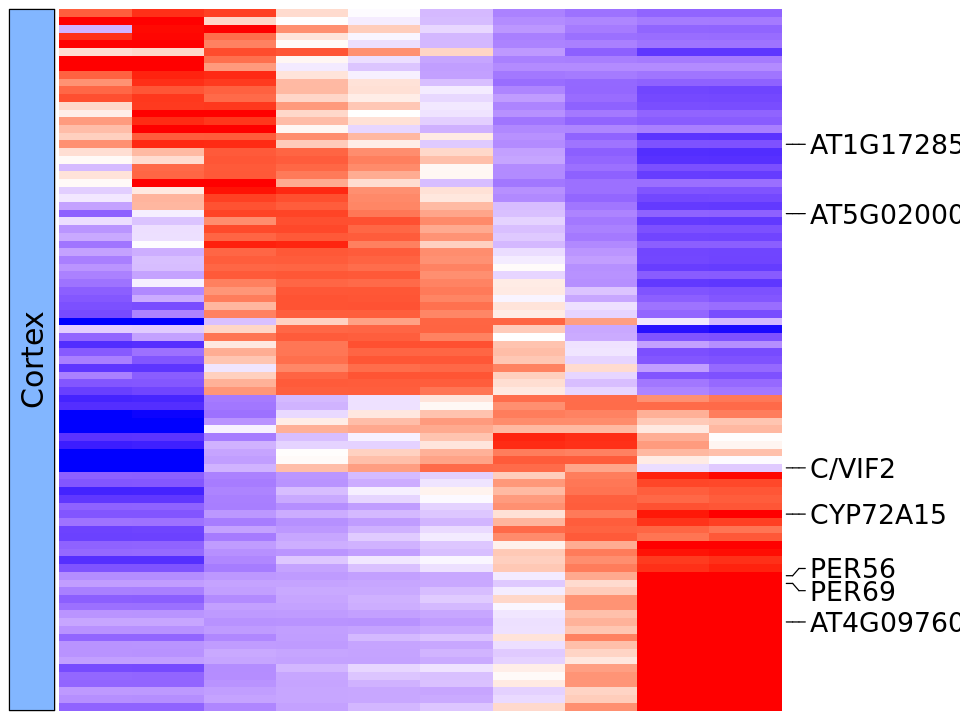

In [54]:
# ['#d8b365','#f5f5f5','#5ab4ac']

Cortex_hm <- Heatmap(mat2, 
        col = colorRamp2(c(-1.5, 0, 1.5), 
                         c('blue','white','red')), 
                show_column_names = F,
                cluster_columns = F,
        cluster_rows=F,
                show_row_names = F, 
        show_heatmap_legend = F, 
        left_annotation=cortex_sa, 
        right_annotation=cor_mark_anno)

Cortex_hm



In [55]:
# text annotation for consensus time

ht = columnAnnotation(foo = anno_text(c("T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9"), rot = 0, just = "center", gp = gpar(fontsize = 16)))

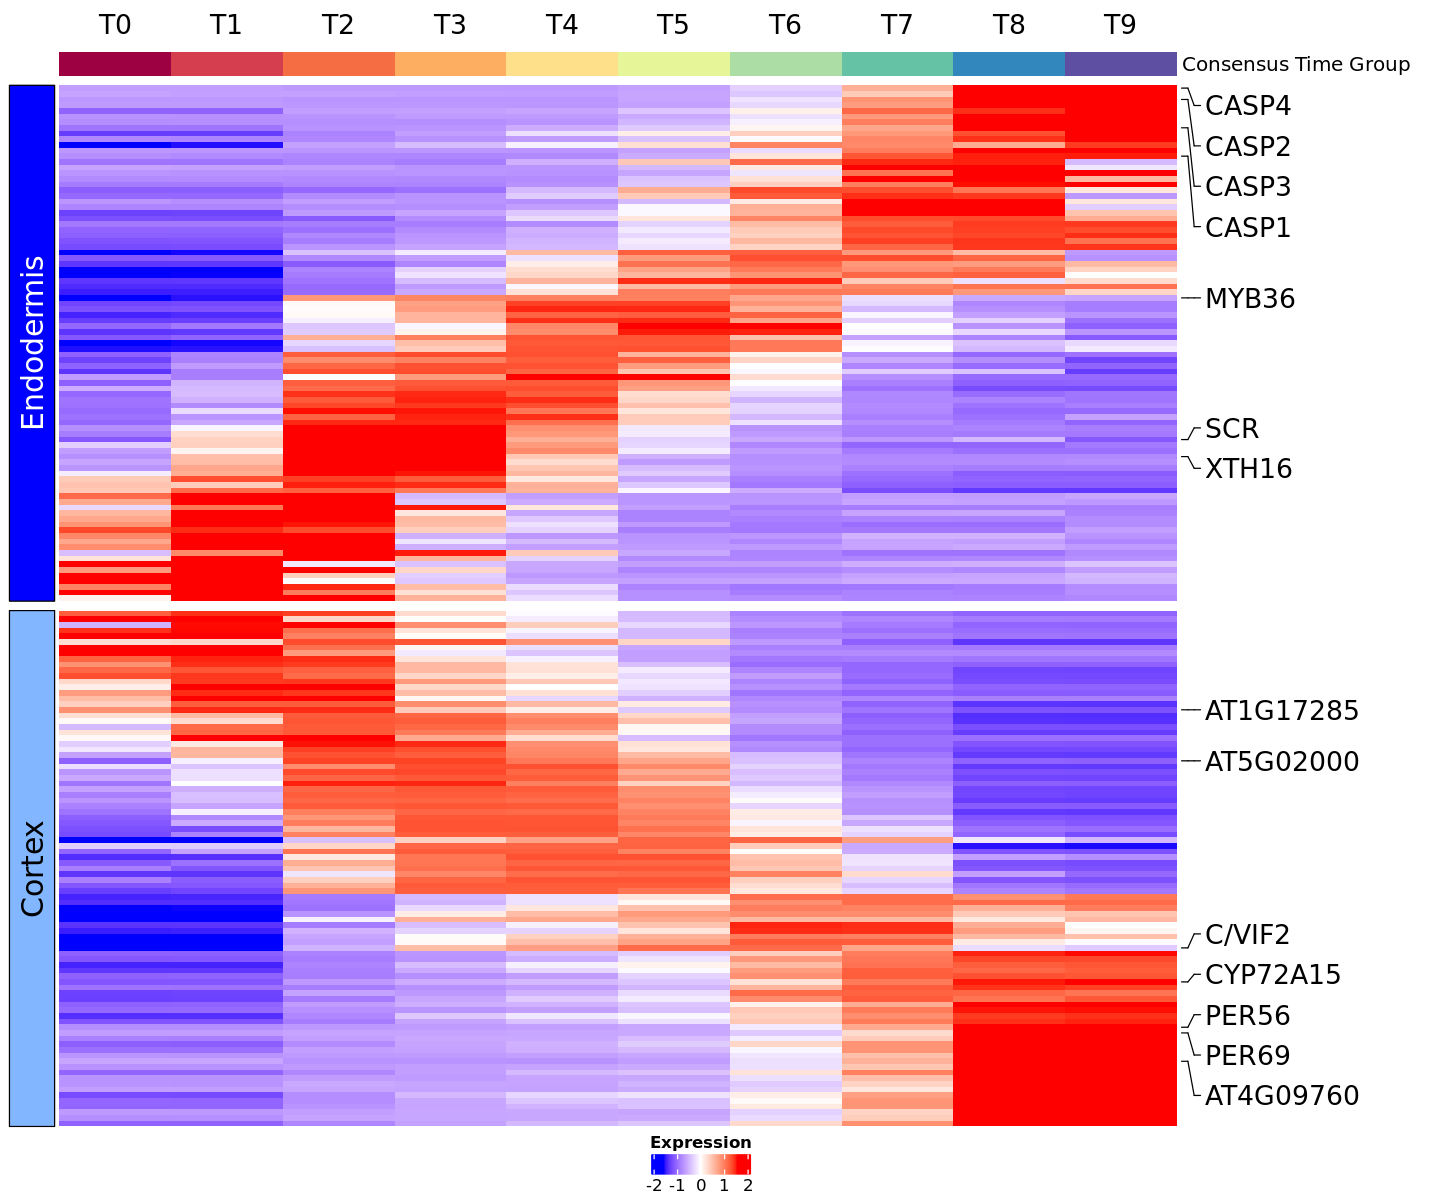

In [56]:
options(repr.plot.width=12, repr.plot.height=10)


ht_list = ht %v% ha %v% Endo_hm %v% Cortex_hm

draw(ht_list, ht_gap = unit(0.2, "cm"), padding = unit(c(2, 2, 5, 10), "mm"), heatmap_legend_side = "bottom")
# grab heatmap as a grob to arrange in cowplot
hm_final <- grid.grabExpr(draw(ht_list, ht_gap = unit(0.2, "cm"), padding = unit(c(2, 2, 5, 10), "mm"), heatmap_legend_side = "bottom"))## bottom, left, top and right



In [57]:
# output heatmap as pdf

pdf("./supp_data/WT_Ground_tissue_heatmap.pdf", width = 12, height = 10)
draw(ht_list, ht_gap = unit(0.2, "cm"), padding = unit(c(2, 2, 5, 10), "mm"), heatmap_legend_side = "bottom") ## bottom, left, top and right
dev.off()

png 
  2

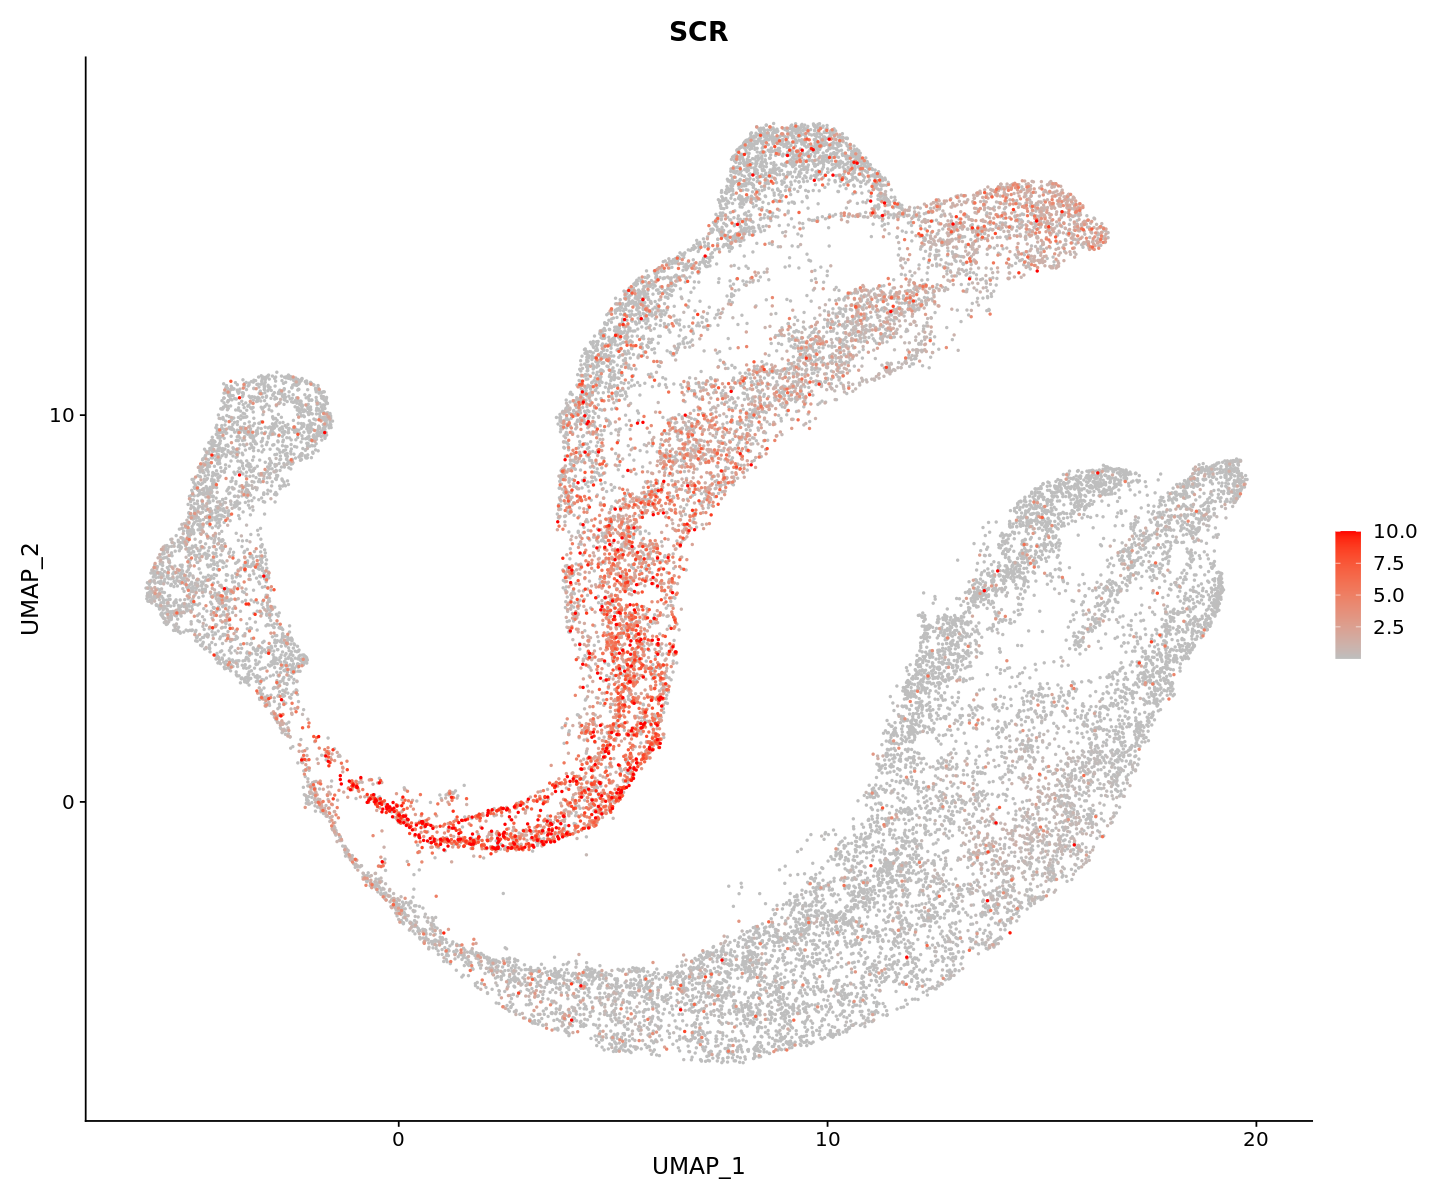

In [58]:
DefaultAssay(rc.integrated) <- "integrated"


(SCR <- FeaturePlot(rc.integrated, features = "AT3G54220",
    cols = c("grey", "red"), label=F, repel=F, pt.size = 0.3, order = T, min.cutoff = "q1", max.cutoff = "q99") + ggtitle("SCR"))

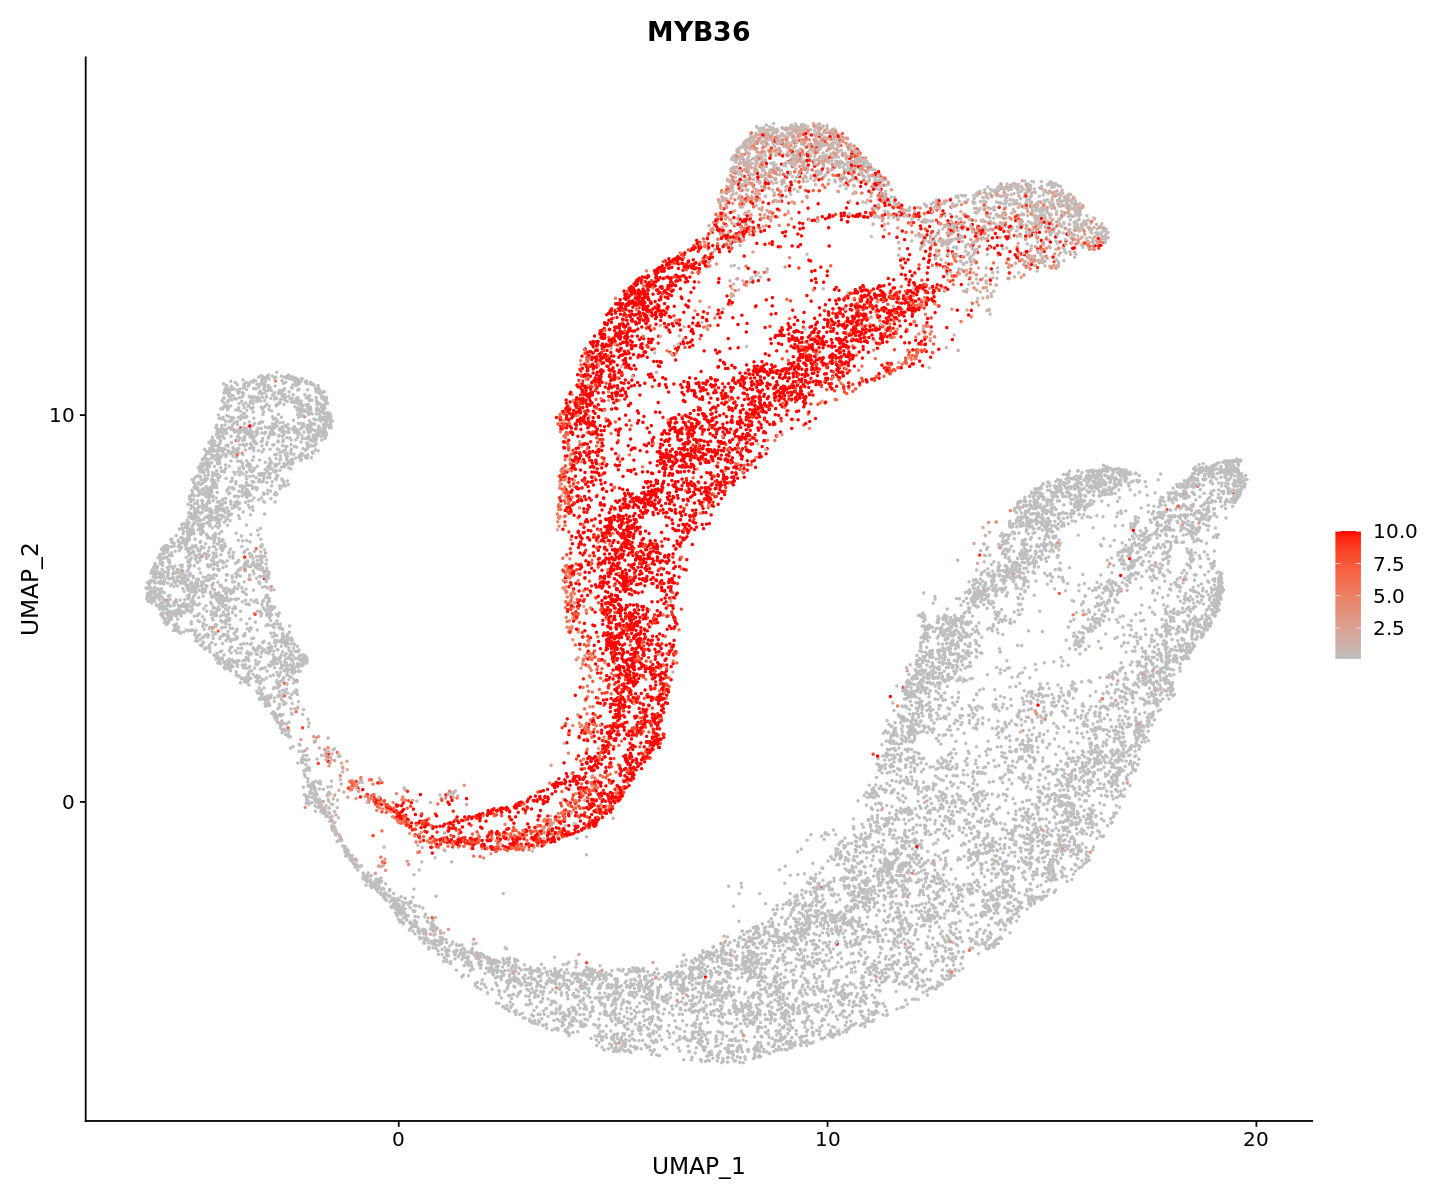

In [59]:
(MYB36 <- FeaturePlot(rc.integrated, features = "AT5G57620",
    cols = c("grey", "red"), label=F, repel=F, pt.size = 0.3, order = F, min.cutoff = "q1", max.cutoff = "q99") + ggtitle("MYB36"))


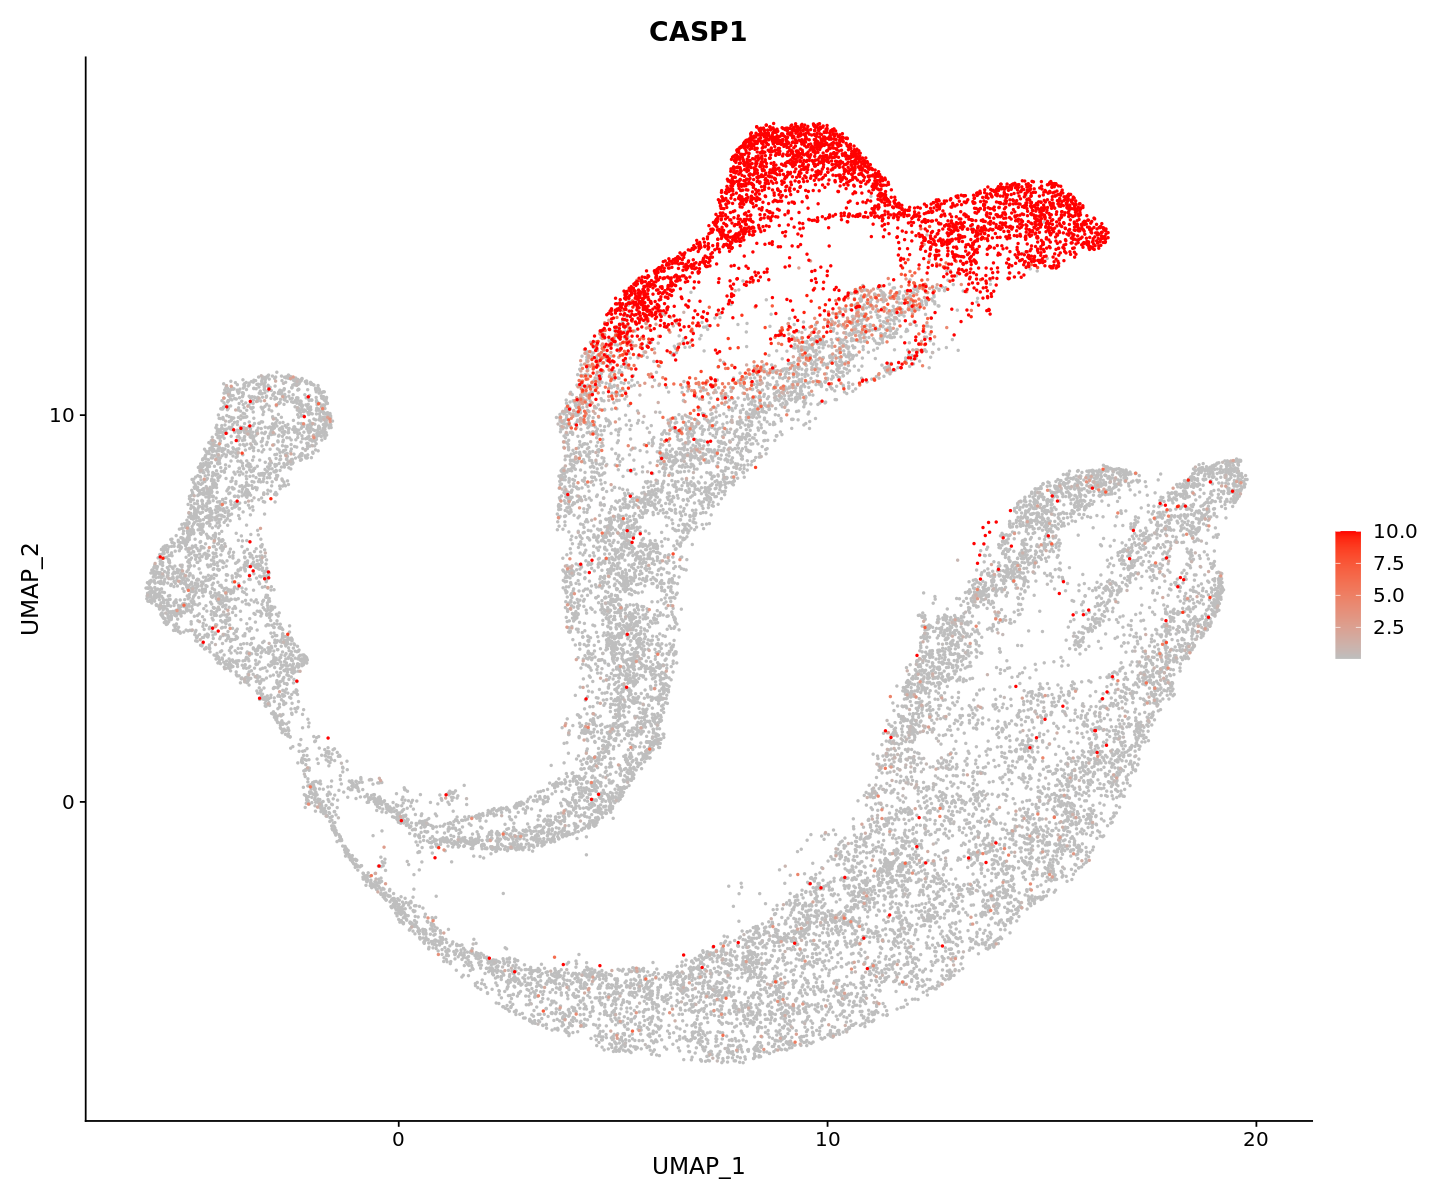

In [60]:
(CASP <- FeaturePlot(rc.integrated, features = "AT2G36100",
    cols = c("grey", "red"), label=F, repel=F, pt.size = 0.3, order = T, min.cutoff = "q1", max.cutoff = "q99") + ggtitle("CASP1"))




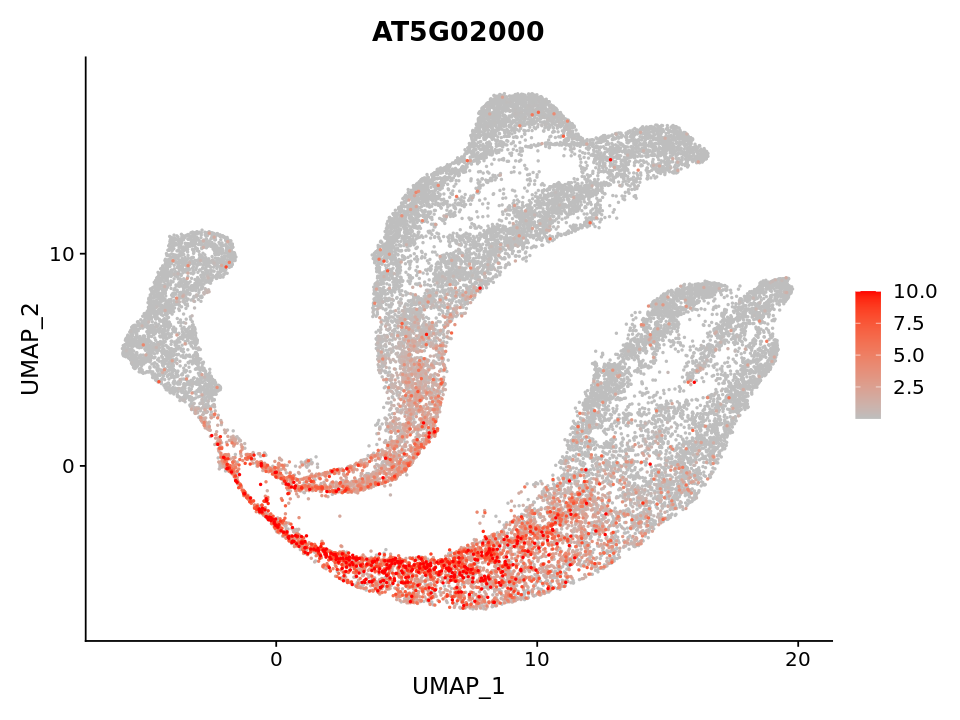

In [61]:
options(repr.plot.width=8, repr.plot.height=6)
(Cor_1 <- FeaturePlot(rc.integrated, features = "AT5G02000",
    cols = c("grey", "red"), label=F, repel=F, pt.size = 0.3, order = T, min.cutoff = "q1", max.cutoff = "q99") + ggtitle("AT5G02000"))


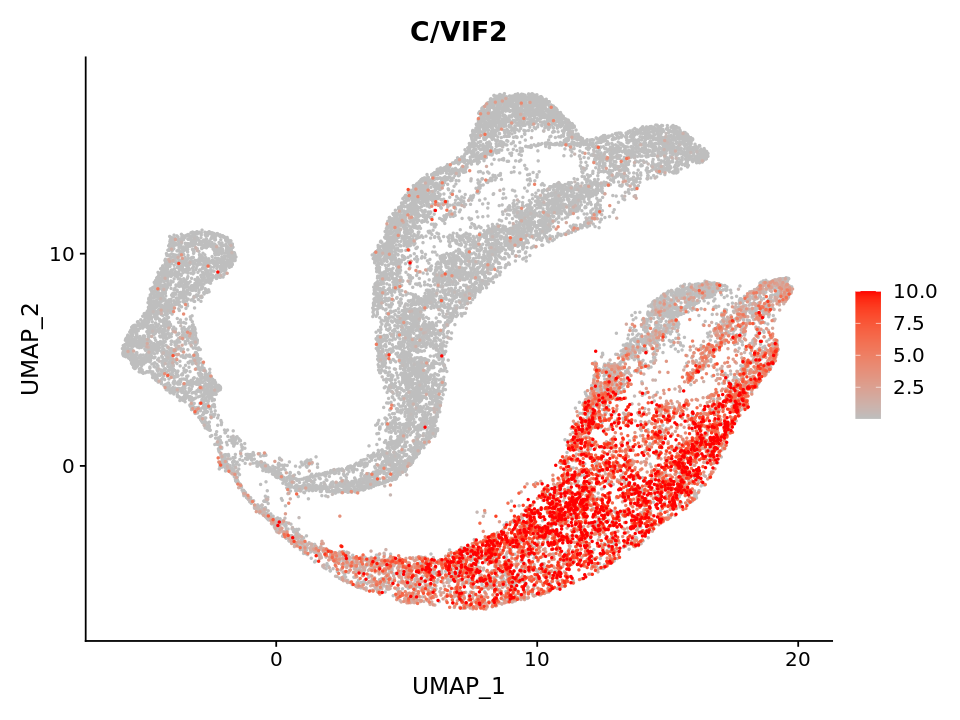

In [62]:
options(repr.plot.width=8, repr.plot.height=6)
(Cor_2 <- FeaturePlot(rc.integrated, features = "AT5G64620",
    cols = c("grey", "red"), label=F, repel=F, pt.size = 0.3, order = T, min.cutoff = "q1", max.cutoff = "q99") + ggtitle("C/VIF2"))


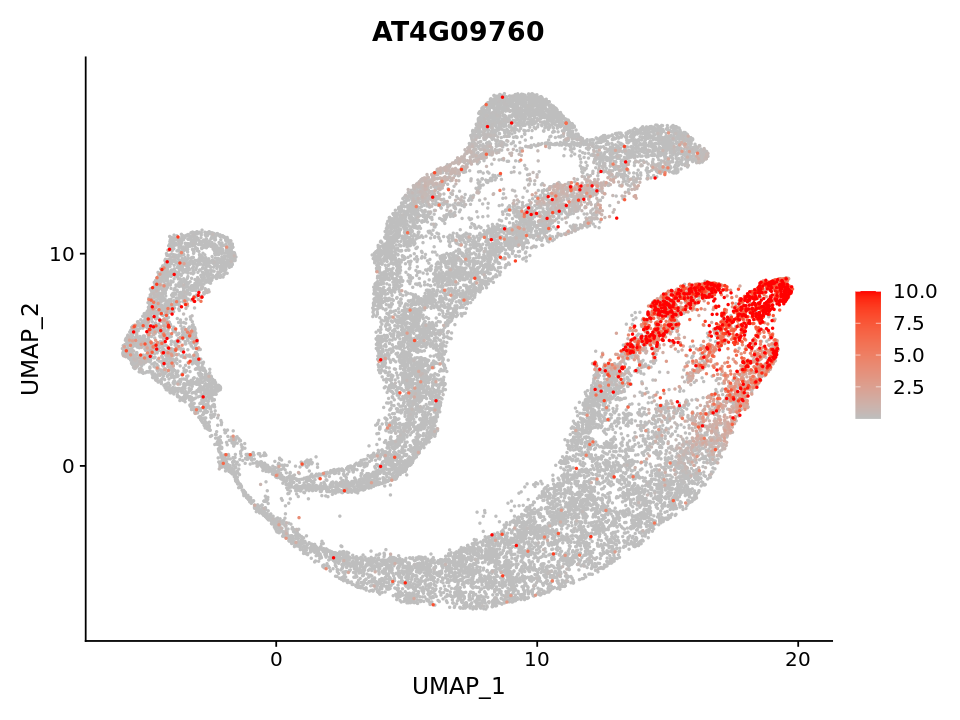

In [63]:
options(repr.plot.width=8, repr.plot.height=6)
(Cor_3 <- FeaturePlot(rc.integrated, features = "AT4G09760",
    cols = c("grey", "red"), label=F, repel=F, pt.size = 0.3, order = T, min.cutoff = "q1", max.cutoff = "q99") + ggtitle("AT4G09760"))


In [64]:
plot_anno <- function(rc.integrated){
order <- c("Quiescent Center", "Stem Cell Niche", "Columella", "Lateral Root Cap", "Atrichoblast", "Trichoblast", "Cortex", "Endodermis", "Pericycle", "Phloem", "Xylem", "Procambium", "Unknown")
palette <- c("#9400D3","#DCD0FF", "#5AB953", "#BFEF45", "#008080", "#21B6A8", "#82B6FF", "#0000FF","#FF9900","#E6194B", "#9A6324", "#FFE119","#EEEEEE")
rc.integrated$celltype.anno <- factor(rc.integrated$celltype.anno, levels = order[sort(match(unique(rc.integrated$celltype.anno),order))])
color <- palette[sort(match(unique(rc.integrated$celltype.anno),order))]
p1 <- DimPlot(rc.integrated, reduction = "umap", group.by = "celltype.anno", cols=color) + ggtitle("Cell Type") + theme(plot.title = element_text(hjust = 0.5))
p2 <- DimPlot(rc.integrated, reduction = "umap", group.by = "time.anno", order = c("Maturation","Elongation","Meristem"),cols = c("#DCEDC8", "#42B3D5", "#1A237E")) + ggtitle("Developmental Stage") + theme(plot.title = element_text(hjust = 0.5))
p3 <- DimPlot(rc.integrated, reduction = "umap", group.by = "consensus.time.group", cols=brewer.pal(10,"Spectral")) + ggtitle("Consensus Time") + theme(plot.title = element_text(hjust = 0.5))
options(repr.plot.width=25, repr.plot.height=8)
gl <- lapply(list(p1, p2, p3), ggplotGrob)
gwidth <- do.call(unit.pmax, lapply(gl, "[[", "widths"))
gl <- lapply(gl, "[[<-", "widths", value = gwidth)
gridExtra::grid.arrange(grobs=gl, ncol=3)
}

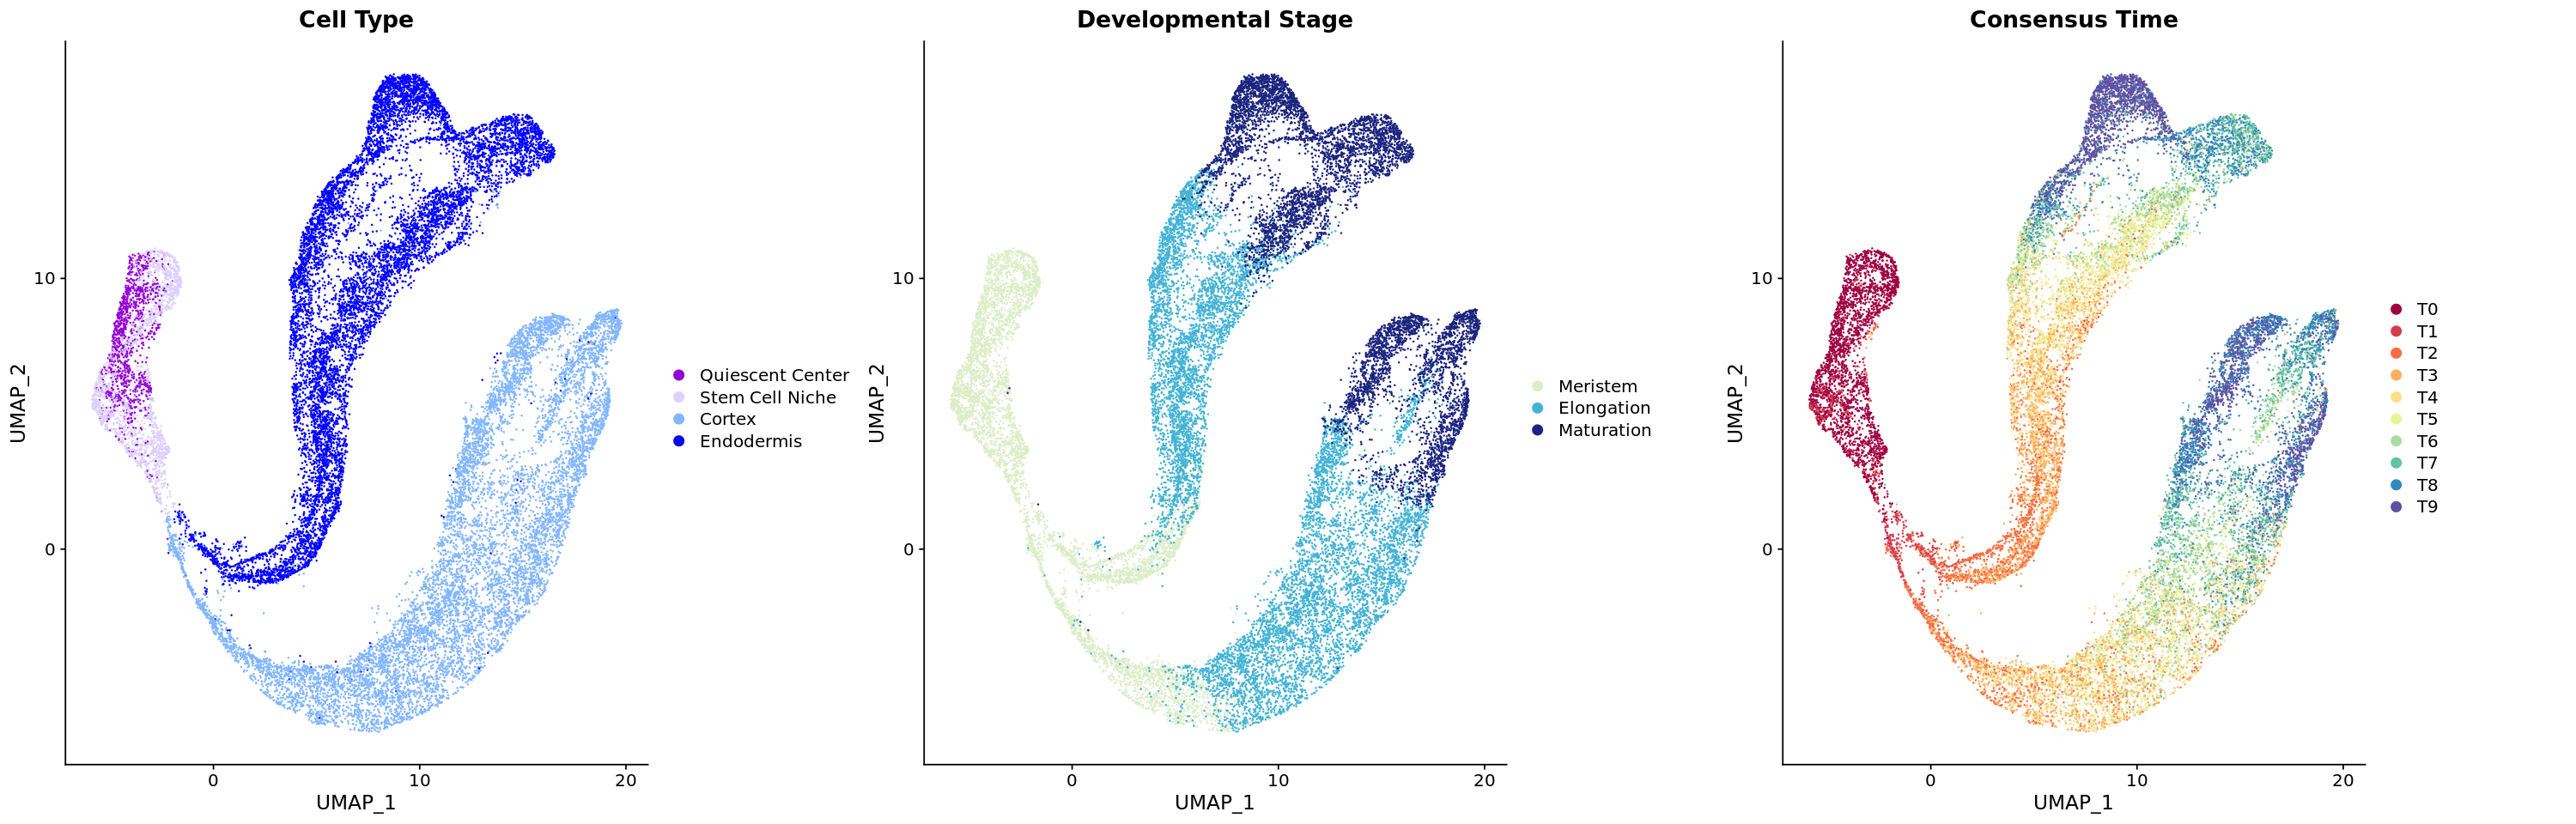

In [65]:
options(repr.plot.width=28, repr.plot.height=6)
top_umaps <- plot_anno(rc.integrated)

In [66]:
options(repr.plot.width=24, repr.plot.height=18)

gene_umaps <- plot_grid(SCR, MYB36, CASP, Cor_1, Cor_2, Cor_3, ncol=3, align="hv")

gene_hm <- plot_grid(gene_umaps, hm_final, ncol=2, rel_widths = c(1.6, 1))

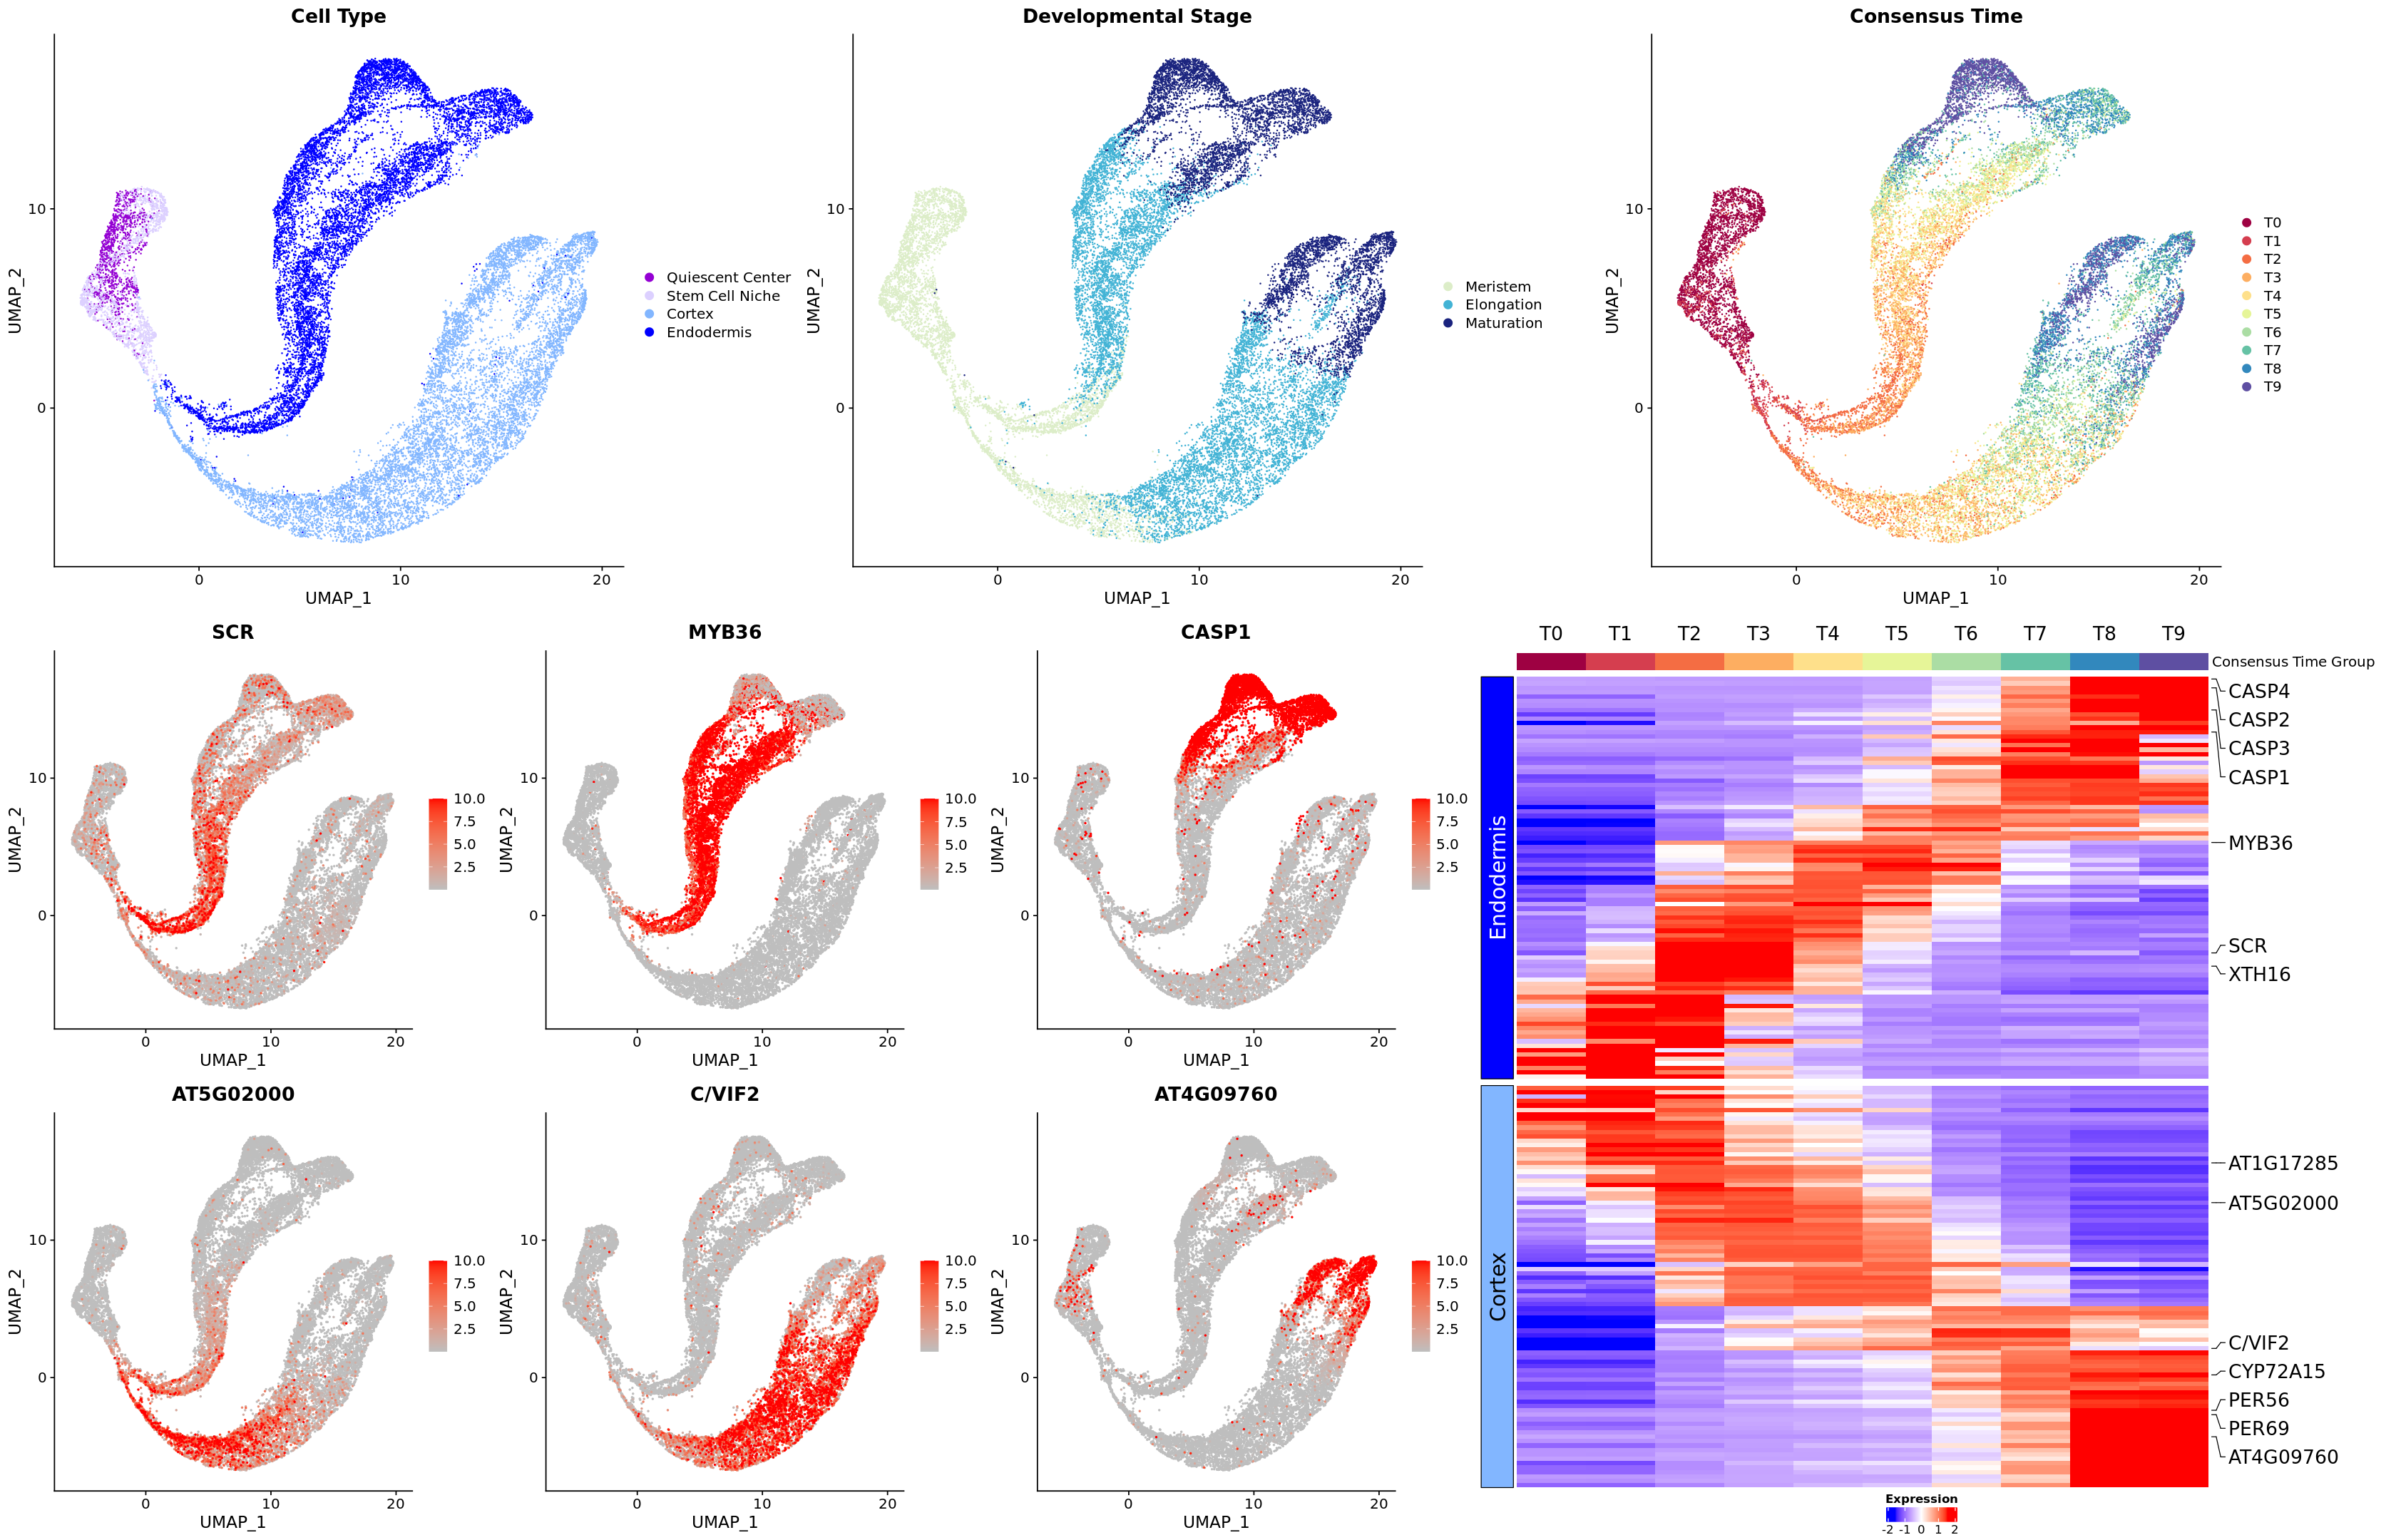

In [67]:
options(repr.plot.width=28, repr.plot.height=18)

plot_grid(top_umaps, gene_hm, ncol=1, rel_heights = c(1, 1.5))

In [68]:
ggsave("./supp_data/Endo_cortex_traj_combined.pdf",
  width = 28,
  height = 18)

In [69]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 16.04.6 LTS

Matrix products: default
BLAS/LAPACK: /home/tmnolan7/anaconda3/envs/r_3.6.1/lib/libopenblasp-r0.3.7.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggrepel_0.8.2        circlize_0.4.8       ComplexHeatmap_2.2.0
 [4] cowplot_1.0.0        future_1.17.0        RColorBrewer_1.1-2  
 [7] Seurat_3.1.5         forcats_0.5.0        stringr_1.4.0       
[10] dplyr_0.8.5          purrr_0.3.3          readr_1.3.1         
[13] tidyr_1